In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

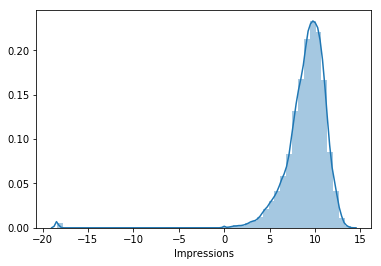

In [3]:
sns.distplot(np.log(df_train_Y['Impressions'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Impressions']:
    df_train_Y['Impressions_log'] = df_train_Y['Impressions'].apply(log)
    df_val_Y['Impressions_log'] = df_val_Y['Impressions'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Impressions_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Impressions_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.43800913886514065, 'colsample_bytree': 0.6000000000000001, 'gamma': 6.004658417628067e-07, 'lambda': 1.995582785666763e-05, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 0.6358916397593671, 'n_estimators': 849.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:5.40621	eval-rmse:5.50813                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.36591	eval-rmse:3.38827                                                                               

[2]	train-rmse:2.18954	eval-rmse:2.15038                                                                         

[27]	train-rmse:1.18806	eval-rmse:0.838687                                                                             

[28]	train-rmse:1.18583	eval-rmse:0.838955                                                                             

Stopping. Best iteration:                                                                                              
[8]	train-rmse:1.31981	eval-rmse:0.730063


loss: 2514828356.4799094                                                                                               
Training with params:                                                                                                  
{'alpha': 1.2316434085793529e-05, 'colsample_bytree': 0.6000000000000001, 'gamma': 9.158905480761617e-06, 'lambda': 5.975503277075764, 'learning_rate': 0.125, 'max_depth': 9, 'min_child_weight': 1.3073394720488007, 'n_estimators': 780.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:7.78924	eval-rmse:7.97127                 

{'alpha': 9.423209418989489e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.015477402944342454, 'lambda': 0.3601626807521826, 'learning_rate': 0.17500000000000002, 'max_depth': 5, 'min_child_weight': 3.6941493216038883, 'n_estimators': 696.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:7.35964	eval-rmse:7.51741                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.12256	eval-rmse:6.20827                                                                               

[2]	train-rmse:5.1149	eval-rmse:5.13215                                                                                

[3]	train-rmse:4.29037	eval-rmse:4.24541                                            

[63]	train-rmse:1.10457	eval-rmse:0.771259                                                                             

[64]	train-rmse:1.10255	eval-rmse:0.770899                                                                             

[65]	train-rmse:1.10064	eval-rmse:0.768757                                                                             

[66]	train-rmse:1.09868	eval-rmse:0.770784                                                                             

[67]	train-rmse:1.09641	eval-rmse:0.769721                                                                             

[68]	train-rmse:1.0946	eval-rmse:0.769719                                                                              

[69]	train-rmse:1.09333	eval-rmse:0.775026                                                                             

[70]	train-rmse:1.09193	eval-rmse:0.774993                                                                             

[71]	train-rmse:1.08971	eval-rms

[24]	train-rmse:1.20634	eval-rmse:1.15234                                                                              

[25]	train-rmse:1.20029	eval-rmse:1.15162                                                                              

[26]	train-rmse:1.19171	eval-rmse:1.15812                                                                              

[27]	train-rmse:1.18684	eval-rmse:1.16912                                                                              

[28]	train-rmse:1.18241	eval-rmse:1.16341                                                                              

[29]	train-rmse:1.17894	eval-rmse:1.16352                                                                              

[30]	train-rmse:1.17321	eval-rmse:1.16351                                                                              

[31]	train-rmse:1.16695	eval-rmse:1.16061                                                                              

Stopping. Best iteration:       

[9]	train-rmse:6.9327	eval-rmse:7.06835                                                                                

[10]	train-rmse:6.76549	eval-rmse:6.89208                                                                              

[11]	train-rmse:6.60244	eval-rmse:6.72062                                                                              

[12]	train-rmse:6.44357	eval-rmse:6.55286                                                                              

[13]	train-rmse:6.28879	eval-rmse:6.39018                                                                              

[14]	train-rmse:6.138	eval-rmse:6.23097                                                                                

[15]	train-rmse:5.99108	eval-rmse:6.07604                                                                              

[16]	train-rmse:5.84824	eval-rmse:5.9243                                                                               

[17]	train-rmse:5.70888	eval-rms

[76]	train-rmse:1.69529	eval-rmse:1.43102                                                                              

[77]	train-rmse:1.67038	eval-rmse:1.40733                                                                              

[78]	train-rmse:1.64689	eval-rmse:1.38004                                                                              

[79]	train-rmse:1.62412	eval-rmse:1.35369                                                                              

[80]	train-rmse:1.60237	eval-rmse:1.3276                                                                               

[81]	train-rmse:1.58117	eval-rmse:1.30261                                                                              

[82]	train-rmse:1.55998	eval-rmse:1.27822                                                                              

[83]	train-rmse:1.54032	eval-rmse:1.25496                                                                              

[84]	train-rmse:1.52096	eval-rms

[3]	train-rmse:1.53647	eval-rmse:0.975986                                                                              

[4]	train-rmse:1.40968	eval-rmse:0.797388                                                                              

[5]	train-rmse:1.36325	eval-rmse:0.739986                                                                              

[6]	train-rmse:1.34724	eval-rmse:0.725716                                                                              

[7]	train-rmse:1.33556	eval-rmse:0.725759                                                                              

[8]	train-rmse:1.32015	eval-rmse:0.726994                                                                              

[9]	train-rmse:1.30896	eval-rmse:0.724385                                                                              

[10]	train-rmse:1.30409	eval-rmse:0.748601                                                                             

[11]	train-rmse:1.29614	eval-rms

loss: 3900561862.2014236                                                                                               
Training with params:                                                                                                  
{'alpha': 2.175810398208477e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0026503446872352247, 'lambda': 0.07223328095427028, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 0.16211279192230518, 'n_estimators': 994.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.43489	eval-rmse:8.64785                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.02434	eval-rmse:8.2174                                                                         

[61]	train-rmse:1.22479	eval-rmse:0.82198                                                                              

[62]	train-rmse:1.21605	eval-rmse:0.832314                                                                             

[63]	train-rmse:1.20815	eval-rmse:0.82458                                                                              

[64]	train-rmse:1.202	eval-rmse:0.817888                                                                               

[65]	train-rmse:1.19472	eval-rmse:0.842744                                                                             

[66]	train-rmse:1.18863	eval-rmse:0.83774                                                                              

[67]	train-rmse:1.18334	eval-rmse:0.832071                                                                             

[68]	train-rmse:1.17808	eval-rmse:0.828688                                                                             

[69]	train-rmse:1.17257	eval-rms

[22]	train-rmse:1.05065	eval-rmse:0.809242                                                                             

[23]	train-rmse:1.02177	eval-rmse:0.79428                                                                              

[24]	train-rmse:1.00084	eval-rmse:0.778058                                                                             

[25]	train-rmse:0.980585	eval-rmse:0.76726                                                                             

[26]	train-rmse:0.963822	eval-rmse:0.758662                                                                            

[27]	train-rmse:0.948095	eval-rmse:0.783808                                                                            

[28]	train-rmse:0.937389	eval-rmse:0.776585                                                                            

[29]	train-rmse:0.923581	eval-rmse:0.811052                                                                            

[30]	train-rmse:0.914516	eval-rm

[0]	train-rmse:6.28353	eval-rmse:6.38607                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.49987	eval-rmse:4.49516                                                                               

[2]	train-rmse:3.28547	eval-rmse:3.17544                                                                               

[3]	train-rmse:2.47884	eval-rmse:2.2678                                                                                

[4]	train-rmse:1.95612	eval-rmse:1.65732                                                                               

[5]	train-rmse:1.62926	eval-rmse:1.25088                                                                               

[6]	train-rmse:1.43392	eval-rms

[29]	train-rmse:1.49323	eval-rmse:1.07274                                                                              

[30]	train-rmse:1.45311	eval-rmse:1.0214                                                                               

[31]	train-rmse:1.41725	eval-rmse:0.978447                                                                             

[32]	train-rmse:1.38462	eval-rmse:0.940256                                                                             

[33]	train-rmse:1.3577	eval-rmse:0.90615                                                                               

[34]	train-rmse:1.33293	eval-rmse:0.874062                                                                             

[35]	train-rmse:1.31112	eval-rmse:0.847409                                                                             

[36]	train-rmse:1.29173	eval-rmse:0.82447                                                                              

[37]	train-rmse:1.2746	eval-rmse

[7]	train-rmse:1.36726	eval-rmse:0.792976                                                                              

[8]	train-rmse:1.34938	eval-rmse:0.767664                                                                              

[9]	train-rmse:1.33116	eval-rmse:0.758814                                                                              

[10]	train-rmse:1.32544	eval-rmse:0.759765                                                                             

[11]	train-rmse:1.31235	eval-rmse:0.759749                                                                             

[12]	train-rmse:1.30345	eval-rmse:0.762287                                                                             

[13]	train-rmse:1.30077	eval-rmse:0.756003                                                                             

[14]	train-rmse:1.29231	eval-rmse:0.785019                                                                             

[15]	train-rmse:1.28366	eval-rms

[33]	train-rmse:1.21377	eval-rmse:0.896624                                                                             

[34]	train-rmse:1.20569	eval-rmse:1.11557                                                                              

[35]	train-rmse:1.20154	eval-rmse:1.11576                                                                              

[36]	train-rmse:1.19631	eval-rmse:1.11575                                                                              

[37]	train-rmse:1.19364	eval-rmse:1.11473                                                                              

[38]	train-rmse:1.18815	eval-rmse:1.11625                                                                              

Stopping. Best iteration:                                                                                              
[18]	train-rmse:1.29357	eval-rmse:0.703742


loss: 2463815348.429856                                                                                      

{'alpha': 3.0351853182398674e-08, 'colsample_bytree': 0.65, 'gamma': 0.9363949655686001, 'lambda': 6.792728064894684, 'learning_rate': 0.47500000000000003, 'max_depth': 4, 'min_child_weight': 0.6375963167132168, 'n_estimators': 833.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:4.82368	eval-rmse:4.82802                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.80873	eval-rmse:2.60101                                                                               

[2]	train-rmse:1.89858	eval-rmse:1.47124                                                                               

[3]	train-rmse:1.54515	eval-rmse:0.977299                                                           

[28]	train-rmse:4.41831	eval-rmse:4.3927                                                                               

[29]	train-rmse:4.31789	eval-rmse:4.28453                                                                              

[30]	train-rmse:4.22024	eval-rmse:4.17899                                                                              

[31]	train-rmse:4.12514	eval-rmse:4.0765                                                                               

[32]	train-rmse:4.0324	eval-rmse:3.97663                                                                               

[33]	train-rmse:3.94244	eval-rmse:3.87957                                                                              

[34]	train-rmse:3.85505	eval-rmse:3.78494                                                                              

[35]	train-rmse:3.76986	eval-rmse:3.69261                                                                              

[36]	train-rmse:3.68706	eval-rms

[95]	train-rmse:1.45158	eval-rmse:1.01916                                                                              

[96]	train-rmse:1.44035	eval-rmse:1.00418                                                                              

[97]	train-rmse:1.42952	eval-rmse:0.990006                                                                             

[98]	train-rmse:1.41867	eval-rmse:0.976222                                                                             

[99]	train-rmse:1.40844	eval-rmse:0.962771                                                                             

loss: 425704627.1801244                                                                                                
Training with params:                                                                                                  
{'alpha': 9.075854851784936e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.1588659456452297e-08, 'lambda': 0.0002361764657001075, 'learning_rate':

[56]	train-rmse:2.33711	eval-rmse:2.23759                                                                              

[57]	train-rmse:2.28965	eval-rmse:2.1873                                                                               

[58]	train-rmse:2.24344	eval-rmse:2.13839                                                                              

[59]	train-rmse:2.19903	eval-rmse:2.09045                                                                              

[60]	train-rmse:2.15541	eval-rmse:2.04414                                                                              

[61]	train-rmse:2.11335	eval-rmse:1.99895                                                                              

[62]	train-rmse:2.07204	eval-rmse:1.95482                                                                              

[63]	train-rmse:2.03164	eval-rmse:1.91245                                                                              

[64]	train-rmse:1.99296	eval-rms

[17]	train-rmse:2.59626	eval-rmse:2.33208                                                                              

[18]	train-rmse:2.46045	eval-rmse:2.17403                                                                              

[19]	train-rmse:2.33912	eval-rmse:2.0272                                                                               

[20]	train-rmse:2.23011	eval-rmse:1.89355                                                                              

[21]	train-rmse:2.13099	eval-rmse:1.76946                                                                              

[22]	train-rmse:2.0431	eval-rmse:1.65793                                                                               

[23]	train-rmse:1.96338	eval-rmse:1.55545                                                                              

[24]	train-rmse:1.89297	eval-rmse:1.46455                                                                              

[25]	train-rmse:1.8301	eval-rmse

[84]	train-rmse:1.32533	eval-rmse:0.694139                                                                             

[85]	train-rmse:1.32461	eval-rmse:0.693299                                                                             

[86]	train-rmse:1.32346	eval-rmse:0.693355                                                                             

[87]	train-rmse:1.32262	eval-rmse:0.693327                                                                             

[88]	train-rmse:1.32149	eval-rmse:0.693626                                                                             

[89]	train-rmse:1.32079	eval-rmse:0.69262                                                                              

[90]	train-rmse:1.31964	eval-rmse:0.692654                                                                             

[91]	train-rmse:1.31815	eval-rmse:0.691582                                                                             

[92]	train-rmse:1.31715	eval-rms

[4]	train-rmse:7.84727	eval-rmse:8.02799                                                                               

[5]	train-rmse:7.65876	eval-rmse:7.82765                                                                               

[6]	train-rmse:7.47496	eval-rmse:7.634                                                                                 

[7]	train-rmse:7.29597	eval-rmse:7.44522                                                                               

[8]	train-rmse:7.12155	eval-rmse:7.26138                                                                               

[9]	train-rmse:6.95174	eval-rmse:7.08197                                                                               

[10]	train-rmse:6.78644	eval-rmse:6.9073                                                                               

[11]	train-rmse:6.62529	eval-rmse:6.73659                                                                              

[12]	train-rmse:6.46845	eval-rms

[71]	train-rmse:2.00926	eval-rmse:1.61607                                                                              

[72]	train-rmse:1.98375	eval-rmse:1.58331                                                                              

[73]	train-rmse:1.9592	eval-rmse:1.55129                                                                               

[74]	train-rmse:1.93527	eval-rmse:1.52001                                                                              

[75]	train-rmse:1.9123	eval-rmse:1.49081                                                                               

[76]	train-rmse:1.89008	eval-rmse:1.46165                                                                              

[77]	train-rmse:1.86867	eval-rmse:1.4336                                                                               

[78]	train-rmse:1.84816	eval-rmse:1.40725                                                                              

[79]	train-rmse:1.82831	eval-rms

[32]	train-rmse:1.35658	eval-rmse:0.723525                                                                             

[33]	train-rmse:1.35424	eval-rmse:0.720759                                                                             

[34]	train-rmse:1.35241	eval-rmse:0.718526                                                                             

[35]	train-rmse:1.34938	eval-rmse:0.715554                                                                             

[36]	train-rmse:1.34777	eval-rmse:0.7134                                                                               

[37]	train-rmse:1.34586	eval-rmse:0.713154                                                                             

[38]	train-rmse:1.34307	eval-rmse:0.711755                                                                             

[39]	train-rmse:1.34086	eval-rmse:0.711895                                                                             

[40]	train-rmse:1.33979	eval-rms

[99]	train-rmse:1.26378	eval-rmse:0.680703                                                                             

loss: 2136104356.3085063                                                                                               
Training with params:                                                                                                  
{'alpha': 3.1573803825662427e-07, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0005973796767795421, 'lambda': 1.6431350783299759, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 4.899122877064902, 'n_estimators': 402.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:6.94091	eval-rmse:7.0754                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                           

[1]	train-rmse:7.62892	eval-rmse:7.8008                                                                                

[2]	train-rmse:7.08135	eval-rmse:7.21742                                                                               

[3]	train-rmse:6.57577	eval-rmse:6.68269                                                                               

[4]	train-rmse:6.10948	eval-rmse:6.18779                                                                               

[5]	train-rmse:5.67997	eval-rmse:5.72539                                                                               

[6]	train-rmse:5.28425	eval-rmse:5.30254                                                                               

[7]	train-rmse:4.92056	eval-rmse:4.91278                                                                               

[8]	train-rmse:4.5853	eval-rmse:4.55122                                                                                

[9]	train-rmse:4.27795	eval-rmse

[68]	train-rmse:1.33956	eval-rmse:0.793433                                                                             

[69]	train-rmse:1.33805	eval-rmse:0.793497                                                                             

[70]	train-rmse:1.33668	eval-rmse:0.793613                                                                             

[71]	train-rmse:1.33553	eval-rmse:0.793814                                                                             

[72]	train-rmse:1.33455	eval-rmse:0.795247                                                                             

[73]	train-rmse:1.33342	eval-rmse:0.794365                                                                             

[74]	train-rmse:1.33236	eval-rmse:0.793673                                                                             

[75]	train-rmse:1.33169	eval-rmse:0.792907                                                                             

Stopping. Best iteration:       

[52]	train-rmse:1.21569	eval-rmse:0.674239                                                                             

[53]	train-rmse:1.21265	eval-rmse:0.67228                                                                              

[54]	train-rmse:1.20946	eval-rmse:0.6711                                                                               

[55]	train-rmse:1.20735	eval-rmse:0.67127                                                                              

[56]	train-rmse:1.20332	eval-rmse:0.674254                                                                             

[57]	train-rmse:1.20176	eval-rmse:0.674366                                                                             

[58]	train-rmse:1.19943	eval-rmse:0.675544                                                                             

[59]	train-rmse:1.19711	eval-rmse:0.675273                                                                             

[60]	train-rmse:1.19555	eval-rms

[37]	train-rmse:3.54923	eval-rmse:3.51069                                                                              

[38]	train-rmse:3.46916	eval-rmse:3.42603                                                                              

[39]	train-rmse:3.39094	eval-rmse:3.34228                                                                              

[40]	train-rmse:3.31476	eval-rmse:3.26186                                                                              

[41]	train-rmse:3.2405	eval-rmse:3.18348                                                                               

[42]	train-rmse:3.16887	eval-rmse:3.10654                                                                              

[43]	train-rmse:3.09868	eval-rmse:3.03154                                                                              

[44]	train-rmse:3.03041	eval-rmse:2.95903                                                                              

[45]	train-rmse:2.96391	eval-rms

[0]	train-rmse:6.07196	eval-rmse:6.16296                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.21675	eval-rmse:4.18603                                                                               

[2]	train-rmse:3.00512	eval-rmse:2.8631                                                                                

[3]	train-rmse:2.23883	eval-rmse:2.00447                                                                               

[4]	train-rmse:1.77686	eval-rmse:1.4565                                                                                

[5]	train-rmse:1.5068	eval-rmse:1.1261                                                                                 

[6]	train-rmse:1.35482	eval-rms

[29]	train-rmse:1.35222	eval-rmse:0.707384                                                                             

[30]	train-rmse:1.35044	eval-rmse:0.70645                                                                              

[31]	train-rmse:1.34753	eval-rmse:0.704221                                                                             

[32]	train-rmse:1.3457	eval-rmse:0.702426                                                                              

[33]	train-rmse:1.34105	eval-rmse:0.763136                                                                             

[34]	train-rmse:1.33841	eval-rmse:0.764029                                                                             

[35]	train-rmse:1.33544	eval-rmse:0.7627                                                                               

[36]	train-rmse:1.33421	eval-rmse:0.761719                                                                             

[37]	train-rmse:1.33188	eval-rms

[35]	train-rmse:1.15564	eval-rmse:0.754095                                                                             

[36]	train-rmse:1.14751	eval-rmse:0.798838                                                                             

[37]	train-rmse:1.13864	eval-rmse:0.858814                                                                             

[38]	train-rmse:1.13165	eval-rmse:0.854949                                                                             

[39]	train-rmse:1.12681	eval-rmse:0.853139                                                                             

[40]	train-rmse:1.1219	eval-rmse:0.853038                                                                              

[41]	train-rmse:1.1178	eval-rmse:0.851136                                                                              

[42]	train-rmse:1.11293	eval-rmse:0.849084                                                                             

[43]	train-rmse:1.10743	eval-rms

Training with params:                                                                                                  
{'alpha': 0.00026300033252685224, 'colsample_bytree': 0.9, 'gamma': 3.693595818804514e-08, 'lambda': 0.704772661600455, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1.5162210645691652, 'n_estimators': 763.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.43789	eval-rmse:8.65111                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.03028	eval-rmse:8.22249                                                                               

[2]	train-rmse:7.64436	eval-rmse:7.81212                                                                               

[3]	tra

[62]	train-rmse:1.41958	eval-rmse:0.789711                                                                             

[63]	train-rmse:1.41437	eval-rmse:0.781308                                                                             

[64]	train-rmse:1.40898	eval-rmse:0.774813                                                                             

[65]	train-rmse:1.40398	eval-rmse:0.768135                                                                             

[66]	train-rmse:1.39939	eval-rmse:0.762832                                                                             

[67]	train-rmse:1.3959	eval-rmse:0.757616                                                                              

[68]	train-rmse:1.39238	eval-rmse:0.751696                                                                             

[69]	train-rmse:1.38872	eval-rmse:0.748186                                                                             

[70]	train-rmse:1.38569	eval-rms

[23]	train-rmse:1.03577	eval-rmse:1.2135                                                                               

[24]	train-rmse:1.03041	eval-rmse:1.2118                                                                               

[25]	train-rmse:1.02634	eval-rmse:1.21207                                                                              

[26]	train-rmse:1.02012	eval-rmse:1.21371                                                                              

[27]	train-rmse:1.01645	eval-rmse:1.21373                                                                              

[28]	train-rmse:1.00923	eval-rmse:1.22193                                                                              

[29]	train-rmse:1.00468	eval-rmse:1.23806                                                                              

[30]	train-rmse:0.999016	eval-rmse:1.23807                                                                             

Stopping. Best iteration:       

[3]	train-rmse:7.25803	eval-rmse:7.41775                                                                               

[4]	train-rmse:6.90553	eval-rmse:7.04801                                                                               

[5]	train-rmse:6.57147	eval-rmse:6.69466                                                                               

[6]	train-rmse:6.25383	eval-rmse:6.36128                                                                               

[7]	train-rmse:5.95238	eval-rmse:6.04356                                                                               

[8]	train-rmse:5.66644	eval-rmse:5.7425                                                                                

[9]	train-rmse:5.39513	eval-rmse:5.45642                                                                               

[10]	train-rmse:5.13774	eval-rmse:5.18654                                                                              

[11]	train-rmse:4.89405	eval-rms

[70]	train-rmse:0.9358	eval-rmse:0.776611                                                                              

[71]	train-rmse:0.93019	eval-rmse:0.77349                                                                              

[72]	train-rmse:0.923553	eval-rmse:0.783711                                                                            

[73]	train-rmse:0.918781	eval-rmse:0.781479                                                                            

[74]	train-rmse:0.913755	eval-rmse:0.778585                                                                            

[75]	train-rmse:0.909058	eval-rmse:0.776637                                                                            

[76]	train-rmse:0.904724	eval-rmse:0.774543                                                                            

[77]	train-rmse:0.900783	eval-rmse:0.772266                                                                            

[78]	train-rmse:0.895469	eval-rm

[31]	train-rmse:1.31917	eval-rmse:0.6973                                                                               

[32]	train-rmse:1.31685	eval-rmse:0.696918                                                                             

[33]	train-rmse:1.31486	eval-rmse:0.693253                                                                             

[34]	train-rmse:1.31283	eval-rmse:0.692399                                                                             

[35]	train-rmse:1.3121	eval-rmse:0.691901                                                                              

[36]	train-rmse:1.30994	eval-rmse:0.688738                                                                             

[37]	train-rmse:1.30781	eval-rmse:0.688766                                                                             

[38]	train-rmse:1.30555	eval-rmse:0.688443                                                                             

[39]	train-rmse:1.30322	eval-rms

[4]	train-rmse:3.54341	eval-rmse:3.49605                                                                               

[5]	train-rmse:2.98315	eval-rmse:2.90096                                                                               

[6]	train-rmse:2.52993	eval-rmse:2.41469                                                                               

[7]	train-rmse:2.16426	eval-rmse:2.01899                                                                               

[8]	train-rmse:1.87346	eval-rmse:1.69979                                                                               

[9]	train-rmse:1.64315	eval-rmse:1.44974                                                                               

[10]	train-rmse:1.4629	eval-rmse:1.24974                                                                               

[11]	train-rmse:1.32244	eval-rmse:1.09706                                                                              

[12]	train-rmse:1.21403	eval-rms

[18]	train-rmse:1.71733	eval-rmse:1.36633                                                                              

[19]	train-rmse:1.63213	eval-rmse:1.25853                                                                              

[20]	train-rmse:1.56004	eval-rmse:1.16641                                                                              

[21]	train-rmse:1.49643	eval-rmse:1.08621                                                                              

[22]	train-rmse:1.4431	eval-rmse:1.01851                                                                               

[23]	train-rmse:1.39807	eval-rmse:0.956071                                                                             

[24]	train-rmse:1.3582	eval-rmse:0.907779                                                                              

[25]	train-rmse:1.32383	eval-rmse:0.866156                                                                             

[26]	train-rmse:1.29681	eval-rms

[25]	train-rmse:4.77125	eval-rmse:4.75368                                                                              

[26]	train-rmse:4.66365	eval-rmse:4.63724                                                                              

[27]	train-rmse:4.55898	eval-rmse:4.52318                                                                              

[28]	train-rmse:4.45703	eval-rmse:4.41296                                                                              

[29]	train-rmse:4.35802	eval-rmse:4.30489                                                                              

[30]	train-rmse:4.26162	eval-rmse:4.19909                                                                              

[31]	train-rmse:4.16792	eval-rmse:4.0966                                                                               

[32]	train-rmse:4.0768	eval-rmse:3.99667                                                                               

[33]	train-rmse:3.98815	eval-rms

[92]	train-rmse:1.6381	eval-rmse:1.10782                                                                               

[93]	train-rmse:1.62675	eval-rmse:1.09124                                                                              

[94]	train-rmse:1.61584	eval-rmse:1.07639                                                                              

[95]	train-rmse:1.60526	eval-rmse:1.06002                                                                              

[96]	train-rmse:1.59537	eval-rmse:1.04651                                                                              

[97]	train-rmse:1.58571	eval-rmse:1.03171                                                                              

[98]	train-rmse:1.5764	eval-rmse:1.01806                                                                               

[99]	train-rmse:1.56763	eval-rmse:1.00453                                                                              

loss: 334554886.3840027         

[6]	train-rmse:3.17016	eval-rmse:2.98718                                                                               

[7]	train-rmse:2.8012	eval-rmse:2.56617                                                                                

[8]	train-rmse:2.49706	eval-rmse:2.21254                                                                               

[9]	train-rmse:2.25222	eval-rmse:1.91569                                                                               

[10]	train-rmse:2.05698	eval-rmse:1.66723                                                                              

[11]	train-rmse:1.89984	eval-rmse:1.4616                                                                               

[12]	train-rmse:1.77591	eval-rmse:1.30247                                                                              

[13]	train-rmse:1.68055	eval-rmse:1.16886                                                                              

[14]	train-rmse:1.60592	eval-rms

[14]	train-rmse:4.31911	eval-rmse:4.26603                                                                              

[15]	train-rmse:4.12876	eval-rmse:4.05939                                                                              

[16]	train-rmse:3.94952	eval-rmse:3.86259                                                                              

[17]	train-rmse:3.78001	eval-rmse:3.67577                                                                              

[18]	train-rmse:3.62	eval-rmse:3.49733                                                                                 

[19]	train-rmse:3.46803	eval-rmse:3.32888                                                                              

[20]	train-rmse:3.32519	eval-rmse:3.17071                                                                              

[21]	train-rmse:3.1914	eval-rmse:3.02228                                                                               

[22]	train-rmse:3.06547	eval-rms

[81]	train-rmse:1.36613	eval-rmse:0.793209                                                                             

[82]	train-rmse:1.36472	eval-rmse:0.792346                                                                             

[83]	train-rmse:1.36313	eval-rmse:0.789776                                                                             

[84]	train-rmse:1.36182	eval-rmse:0.795188                                                                             

[85]	train-rmse:1.36058	eval-rmse:0.793264                                                                             

[86]	train-rmse:1.35961	eval-rmse:0.798763                                                                             

[87]	train-rmse:1.35835	eval-rmse:0.798477                                                                             

[88]	train-rmse:1.35717	eval-rmse:0.797292                                                                             

[89]	train-rmse:1.35593	eval-rms

{'alpha': 0.00023523931211649686, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.22452135535707635, 'lambda': 0.0008024341349830274, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 0.7841506267852606, 'n_estimators': 577.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:6.26521	eval-rmse:6.389                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.4572	eval-rmse:4.48934                                                                                

[2]	train-rmse:3.21432	eval-rmse:3.17785                                                                               

[3]	train-rmse:2.36654	eval-rmse:2.27385                                                        

[25]	train-rmse:1.07753	eval-rmse:0.82668                                                                              

[26]	train-rmse:1.05904	eval-rmse:0.81606                                                                              

[27]	train-rmse:1.04476	eval-rmse:0.809138                                                                             

[28]	train-rmse:1.03235	eval-rmse:0.862052                                                                             

[29]	train-rmse:1.02193	eval-rmse:0.858409                                                                             

[30]	train-rmse:1.01305	eval-rmse:0.90777                                                                              

[31]	train-rmse:1.00362	eval-rmse:0.976129                                                                             

[32]	train-rmse:0.997267	eval-rmse:0.973933                                                                            

[33]	train-rmse:0.991652	eval-rm

[37]	train-rmse:1.89233	eval-rmse:1.4653                                                                               

[38]	train-rmse:1.84976	eval-rmse:1.40911                                                                              

[39]	train-rmse:1.81007	eval-rmse:1.35841                                                                              

[40]	train-rmse:1.77418	eval-rmse:1.3088                                                                               

[41]	train-rmse:1.74059	eval-rmse:1.26172                                                                              

[42]	train-rmse:1.7098	eval-rmse:1.21816                                                                               

[43]	train-rmse:1.68109	eval-rmse:1.17695                                                                              

[44]	train-rmse:1.65486	eval-rmse:1.13953                                                                              

[45]	train-rmse:1.6307	eval-rmse

[0]	train-rmse:8.21623	eval-rmse:8.41792                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.61436	eval-rmse:7.788                                                                                 

[2]	train-rmse:7.05935	eval-rmse:7.20238                                                                               

[3]	train-rmse:6.54608	eval-rmse:6.66501                                                                               

[4]	train-rmse:6.07143	eval-rmse:6.16803                                                                               

[5]	train-rmse:5.63493	eval-rmse:5.70505                                                                               

[6]	train-rmse:5.23073	eval-rms

Stopping. Best iteration:                                                                                              
[44]	train-rmse:0.962589	eval-rmse:0.792731


loss: 2179869008.595181                                                                                                
Training with params:                                                                                                  
{'alpha': 4.294463965826151e-06, 'colsample_bytree': 0.8, 'gamma': 0.00461913506964713, 'lambda': 0.06276279132181495, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 0.7550524425612656, 'n_estimators': 369.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.72178	eval-rmse:6.84476                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.               

[18]	train-rmse:1.13176	eval-rmse:1.09873                                                                              

[19]	train-rmse:1.11736	eval-rmse:1.10214                                                                              

[20]	train-rmse:1.10915	eval-rmse:1.102                                                                                

[21]	train-rmse:1.10112	eval-rmse:1.1149                                                                               

[22]	train-rmse:1.09119	eval-rmse:1.1081                                                                               

[23]	train-rmse:1.08823	eval-rmse:1.10858                                                                              

[24]	train-rmse:1.08187	eval-rmse:1.10656                                                                              

[25]	train-rmse:1.07622	eval-rmse:1.11063                                                                              

Stopping. Best iteration:       

[52]	train-rmse:1.28784	eval-rmse:0.684635                                                                             

[53]	train-rmse:1.28667	eval-rmse:0.682511                                                                             

[54]	train-rmse:1.28485	eval-rmse:0.682441                                                                             

[55]	train-rmse:1.28331	eval-rmse:0.682452                                                                             

[56]	train-rmse:1.28144	eval-rmse:0.680418                                                                             

[57]	train-rmse:1.27938	eval-rmse:0.681759                                                                             

[58]	train-rmse:1.27804	eval-rmse:0.681762                                                                             

[59]	train-rmse:1.27675	eval-rmse:0.67586                                                                              

[60]	train-rmse:1.27464	eval-rms

[14]	train-rmse:2.07058	eval-rmse:1.97025                                                                              

[15]	train-rmse:1.90784	eval-rmse:1.79974                                                                              

[16]	train-rmse:1.76519	eval-rmse:1.64885                                                                              

[17]	train-rmse:1.63957	eval-rmse:1.51727                                                                              

[18]	train-rmse:1.52694	eval-rmse:1.39928                                                                              

[19]	train-rmse:1.4289	eval-rmse:1.30278                                                                               

[20]	train-rmse:1.34302	eval-rmse:1.21576                                                                              

[21]	train-rmse:1.26972	eval-rmse:1.14119                                                                              

[22]	train-rmse:1.20286	eval-rms

[7]	train-rmse:1.15545	eval-rmse:0.888341                                                                              

[8]	train-rmse:1.12818	eval-rmse:0.876656                                                                              

[9]	train-rmse:1.10332	eval-rmse:1.05227                                                                               

[10]	train-rmse:1.08505	eval-rmse:1.04746                                                                              

[11]	train-rmse:1.06765	eval-rmse:1.046                                                                                

[12]	train-rmse:1.04544	eval-rmse:1.04114                                                                              

[13]	train-rmse:1.03453	eval-rmse:1.03238                                                                              

[14]	train-rmse:1.02351	eval-rmse:1.03242                                                                              

[15]	train-rmse:1.01232	eval-rms

[5]	train-rmse:3.13103	eval-rmse:2.94062                                                                               

[6]	train-rmse:2.70743	eval-rmse:2.45792                                                                               

[7]	train-rmse:2.37516	eval-rmse:2.06554                                                                               

[8]	train-rmse:2.11795	eval-rmse:1.74926                                                                               

[9]	train-rmse:1.92246	eval-rmse:1.49429                                                                               

[10]	train-rmse:1.77483	eval-rmse:1.2924                                                                               

[11]	train-rmse:1.66634	eval-rmse:1.13807                                                                              

[12]	train-rmse:1.58507	eval-rmse:1.02178                                                                              

[13]	train-rmse:1.52568	eval-rms

[12]	train-rmse:6.43721	eval-rmse:6.55254                                                                              

[13]	train-rmse:6.28181	eval-rmse:6.38959                                                                              

[14]	train-rmse:6.13061	eval-rmse:6.23018                                                                              

[15]	train-rmse:5.98291	eval-rmse:6.07488                                                                              

[16]	train-rmse:5.83962	eval-rmse:5.92334                                                                              

[17]	train-rmse:5.69974	eval-rmse:5.77637                                                                              

[18]	train-rmse:5.56345	eval-rmse:5.63258                                                                              

[19]	train-rmse:5.43026	eval-rmse:5.49269                                                                              

[20]	train-rmse:5.30086	eval-rms

[79]	train-rmse:1.55094	eval-rmse:1.3634                                                                               

[80]	train-rmse:1.52804	eval-rmse:1.33937                                                                              

[81]	train-rmse:1.50586	eval-rmse:1.31466                                                                              

[82]	train-rmse:1.4836	eval-rmse:1.29819                                                                               

[83]	train-rmse:1.46272	eval-rmse:1.27639                                                                              

[84]	train-rmse:1.44249	eval-rmse:1.25544                                                                              

[85]	train-rmse:1.42324	eval-rmse:1.23438                                                                              

[86]	train-rmse:1.4039	eval-rmse:1.21898                                                                               

[87]	train-rmse:1.38497	eval-rms

[40]	train-rmse:1.32779	eval-rmse:0.774703                                                                             

[41]	train-rmse:1.32554	eval-rmse:0.772626                                                                             

[42]	train-rmse:1.32287	eval-rmse:0.77335                                                                              

[43]	train-rmse:1.3203	eval-rmse:0.775474                                                                              

[44]	train-rmse:1.31752	eval-rmse:0.77552                                                                              

[45]	train-rmse:1.31569	eval-rmse:0.77404                                                                              

[46]	train-rmse:1.31439	eval-rmse:0.788784                                                                             

[47]	train-rmse:1.30984	eval-rmse:0.89212                                                                              

[48]	train-rmse:1.30865	eval-rms

[38]	train-rmse:0.972741	eval-rmse:1.0893                                                                              

[39]	train-rmse:0.969028	eval-rmse:1.08928                                                                             

[40]	train-rmse:0.960708	eval-rmse:1.08779                                                                             

[41]	train-rmse:0.957746	eval-rmse:1.08784                                                                             

[42]	train-rmse:0.955038	eval-rmse:1.08694                                                                             

[43]	train-rmse:0.951111	eval-rmse:1.087                                                                               

[44]	train-rmse:0.947107	eval-rmse:1.08661                                                                             

[45]	train-rmse:0.94241	eval-rmse:1.13328                                                                              

[46]	train-rmse:0.938536	eval-rm

[9]	train-rmse:4.27715	eval-rmse:4.21662                                                                               

[10]	train-rmse:3.99542	eval-rmse:3.90822                                                                              

[11]	train-rmse:3.73706	eval-rmse:3.62492                                                                              

[12]	train-rmse:3.49899	eval-rmse:3.36313                                                                              

[13]	train-rmse:3.28265	eval-rmse:3.12146                                                                              

[14]	train-rmse:3.0848	eval-rmse:2.89854                                                                               

[15]	train-rmse:2.90511	eval-rmse:2.69571                                                                              

[16]	train-rmse:2.74183	eval-rmse:2.51033                                                                              

[17]	train-rmse:2.59405	eval-rms

[76]	train-rmse:1.32754	eval-rmse:0.792712                                                                             

[77]	train-rmse:1.32565	eval-rmse:0.792762                                                                             

[78]	train-rmse:1.32475	eval-rmse:0.792828                                                                             

Stopping. Best iteration:                                                                                              
[58]	train-rmse:1.35122	eval-rmse:0.777199


loss: 1697797766.3123732                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00014006793507621536, 'colsample_bytree': 0.6000000000000001, 'gamma': 3.422275916052147e-07, 'lambda': 0.2326476952263892, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 7.8477832169749755, 'n_estimators': 

[56]	train-rmse:2.50009	eval-rmse:2.2418                                                                               

[57]	train-rmse:2.45715	eval-rmse:2.19146                                                                              

[58]	train-rmse:2.41545	eval-rmse:2.1415                                                                               

[59]	train-rmse:2.37502	eval-rmse:2.09331                                                                              

[60]	train-rmse:2.33603	eval-rmse:2.04625                                                                              

[61]	train-rmse:2.29814	eval-rmse:2.00009                                                                              

[62]	train-rmse:2.26156	eval-rmse:1.95595                                                                              

[63]	train-rmse:2.22623	eval-rmse:1.91246                                                                              

[64]	train-rmse:2.19208	eval-rms

[17]	train-rmse:0.79799	eval-rmse:1.04599                                                                              

[18]	train-rmse:0.793649	eval-rmse:1.04605                                                                             

[19]	train-rmse:0.784154	eval-rmse:1.0489                                                                              

[20]	train-rmse:0.778976	eval-rmse:1.04905                                                                             

[21]	train-rmse:0.771428	eval-rmse:1.04795                                                                             

[22]	train-rmse:0.762415	eval-rmse:1.21416                                                                             

[23]	train-rmse:0.757466	eval-rmse:1.21522                                                                             

[24]	train-rmse:0.752788	eval-rmse:1.21141                                                                             

[25]	train-rmse:0.749424	eval-rm

{'alpha': 5.396056982978788e-05, 'colsample_bytree': 0.9, 'gamma': 0.0023992602183509934, 'lambda': 0.006495065512154432, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 3.1399250013965148, 'n_estimators': 720.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:8.00037	eval-rmse:8.19087                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.22071	eval-rmse:7.37144                                                                               

[2]	train-rmse:6.52265	eval-rmse:6.63253                                                                               

[3]	train-rmse:5.89477	eval-rmse:5.9698                                                                         

[63]	train-rmse:0.883049	eval-rmse:0.681452                                                                            

[64]	train-rmse:0.880548	eval-rmse:0.681553                                                                            

[65]	train-rmse:0.878784	eval-rmse:0.681718                                                                            

[66]	train-rmse:0.877395	eval-rmse:0.682103                                                                            

[67]	train-rmse:0.875459	eval-rmse:0.680692                                                                            

[68]	train-rmse:0.873688	eval-rmse:0.679777                                                                            

[69]	train-rmse:0.871206	eval-rmse:0.679548                                                                            

[70]	train-rmse:0.869459	eval-rmse:0.679023                                                                            

[71]	train-rmse:0.868	eval-rmse:

[24]	train-rmse:4.8654	eval-rmse:4.86293                                                                               

[25]	train-rmse:4.7542	eval-rmse:4.74351                                                                               

[26]	train-rmse:4.64604	eval-rmse:4.62687                                                                              

[27]	train-rmse:4.54077	eval-rmse:4.51373                                                                              

[28]	train-rmse:4.43833	eval-rmse:4.40313                                                                              

[29]	train-rmse:4.33887	eval-rmse:4.2944                                                                               

[30]	train-rmse:4.24198	eval-rmse:4.1893                                                                               

[31]	train-rmse:4.14777	eval-rmse:4.0872                                                                               

[32]	train-rmse:4.05614	eval-rms

[91]	train-rmse:1.6099	eval-rmse:1.10985                                                                               

[92]	train-rmse:1.59794	eval-rmse:1.09246                                                                              

[93]	train-rmse:1.58654	eval-rmse:1.07617                                                                              

[94]	train-rmse:1.57542	eval-rmse:1.06036                                                                              

[95]	train-rmse:1.56489	eval-rmse:1.04458                                                                              

[96]	train-rmse:1.55477	eval-rmse:1.03029                                                                              

[97]	train-rmse:1.54516	eval-rmse:1.01649                                                                              

[98]	train-rmse:1.53577	eval-rmse:1.00252                                                                              

[99]	train-rmse:1.52673	eval-rms

[52]	train-rmse:1.47291	eval-rmse:0.909922                                                                             

[53]	train-rmse:1.46043	eval-rmse:0.890798                                                                             

[54]	train-rmse:1.44875	eval-rmse:0.873269                                                                             

[55]	train-rmse:1.43834	eval-rmse:0.85748                                                                              

[56]	train-rmse:1.42841	eval-rmse:0.842399                                                                             

[57]	train-rmse:1.41936	eval-rmse:0.829056                                                                             

[58]	train-rmse:1.41076	eval-rmse:0.815201                                                                             

[59]	train-rmse:1.40326	eval-rmse:0.802431                                                                             

[60]	train-rmse:1.39624	eval-rms

[13]	train-rmse:6.30756	eval-rmse:6.40206                                                                              

[14]	train-rmse:6.15829	eval-rmse:6.24219                                                                              

[15]	train-rmse:6.01281	eval-rmse:6.0882                                                                               

[16]	train-rmse:5.87153	eval-rmse:5.93852                                                                              

[17]	train-rmse:5.73354	eval-rmse:5.79164                                                                              

[18]	train-rmse:5.59915	eval-rmse:5.64846                                                                              

[19]	train-rmse:5.46848	eval-rmse:5.50897                                                                              

[20]	train-rmse:5.34121	eval-rmse:5.3733                                                                               

[21]	train-rmse:5.21767	eval-rms

[80]	train-rmse:1.78004	eval-rmse:1.34446                                                                              

[81]	train-rmse:1.76157	eval-rmse:1.31901                                                                              

[82]	train-rmse:1.74392	eval-rmse:1.29462                                                                              

[83]	train-rmse:1.72679	eval-rmse:1.27088                                                                              

[84]	train-rmse:1.71013	eval-rmse:1.24831                                                                              

[85]	train-rmse:1.6944	eval-rmse:1.22667                                                                               

[86]	train-rmse:1.67927	eval-rmse:1.20539                                                                              

[87]	train-rmse:1.6645	eval-rmse:1.1845                                                                                

[88]	train-rmse:1.65026	eval-rms

[41]	train-rmse:1.3776	eval-rmse:0.776439                                                                              

[42]	train-rmse:1.36926	eval-rmse:0.766759                                                                             

[43]	train-rmse:1.36168	eval-rmse:0.75701                                                                              

[44]	train-rmse:1.35465	eval-rmse:0.748873                                                                             

[45]	train-rmse:1.34917	eval-rmse:0.742472                                                                             

[46]	train-rmse:1.34397	eval-rmse:0.735647                                                                             

[47]	train-rmse:1.33938	eval-rmse:0.730461                                                                             

[48]	train-rmse:1.33519	eval-rmse:0.727511                                                                             

[49]	train-rmse:1.33077	eval-rms

[20]	train-rmse:3.30243	eval-rmse:3.15825                                                                              

[21]	train-rmse:3.16771	eval-rmse:3.00944                                                                              

[22]	train-rmse:3.04065	eval-rmse:2.86496                                                                              

[23]	train-rmse:2.92106	eval-rmse:2.72868                                                                              

[24]	train-rmse:2.8091	eval-rmse:2.60135                                                                               

[25]	train-rmse:2.70385	eval-rmse:2.47992                                                                              

[26]	train-rmse:2.60492	eval-rmse:2.36486                                                                              

[27]	train-rmse:2.51201	eval-rmse:2.25639                                                                              

[28]	train-rmse:2.42514	eval-rms

[87]	train-rmse:1.30783	eval-rmse:0.722428                                                                             

[88]	train-rmse:1.30482	eval-rmse:0.721865                                                                             

[89]	train-rmse:1.30337	eval-rmse:0.720786                                                                             

[90]	train-rmse:1.30148	eval-rmse:0.720303                                                                             

[91]	train-rmse:1.30037	eval-rmse:0.719474                                                                             

[92]	train-rmse:1.29884	eval-rmse:0.719274                                                                             

[93]	train-rmse:1.29745	eval-rmse:0.718463                                                                             

[94]	train-rmse:1.29644	eval-rmse:0.718439                                                                             

[95]	train-rmse:1.29594	eval-rms

[48]	train-rmse:1.27708	eval-rmse:0.685737                                                                             

[49]	train-rmse:1.27403	eval-rmse:0.687449                                                                             

[50]	train-rmse:1.27292	eval-rmse:0.687851                                                                             

[51]	train-rmse:1.26922	eval-rmse:0.686093                                                                             

[52]	train-rmse:1.2681	eval-rmse:0.686853                                                                              

[53]	train-rmse:1.26529	eval-rmse:0.686952                                                                             

[54]	train-rmse:1.26252	eval-rmse:0.687005                                                                             

[55]	train-rmse:1.26036	eval-rmse:0.686444                                                                             

[56]	train-rmse:1.2577	eval-rmse

[16]	train-rmse:2.74458	eval-rmse:2.5026                                                                               

[17]	train-rmse:2.59628	eval-rmse:2.32928                                                                              

[18]	train-rmse:2.46102	eval-rmse:2.17062                                                                              

[19]	train-rmse:2.33902	eval-rmse:2.02452                                                                              

[20]	train-rmse:2.22912	eval-rmse:1.8916                                                                               

[21]	train-rmse:2.13113	eval-rmse:1.77468                                                                              

[22]	train-rmse:2.04306	eval-rmse:1.66268                                                                              

[23]	train-rmse:1.96444	eval-rmse:1.56019                                                                              

[24]	train-rmse:1.89334	eval-rms

Stopping. Best iteration:                                                                                              
[62]	train-rmse:1.35455	eval-rmse:0.756841


loss: 1813125228.2426488                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00032425081137261514, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.4325622858211946e-06, 'lambda': 0.00479457557006986, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 9.80657424143, 'n_estimators': 485.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:8.6517	eval-rmse:8.87528                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.               

[60]	train-rmse:2.31045	eval-rmse:2.03336                                                                              

[61]	train-rmse:2.27186	eval-rmse:1.98711                                                                              

[62]	train-rmse:2.23463	eval-rmse:1.94239                                                                              

[63]	train-rmse:2.19869	eval-rmse:1.89858                                                                              

[64]	train-rmse:2.16363	eval-rmse:1.85715                                                                              

[65]	train-rmse:2.13015	eval-rmse:1.81648                                                                              

[66]	train-rmse:2.09759	eval-rmse:1.77669                                                                              

[67]	train-rmse:2.06619	eval-rmse:1.73789                                                                              

[68]	train-rmse:2.03587	eval-rms

[21]	train-rmse:1.62154	eval-rmse:1.12268                                                                              

[22]	train-rmse:1.57449	eval-rmse:1.05404                                                                              

[23]	train-rmse:1.5344	eval-rmse:0.996291                                                                              

[24]	train-rmse:1.5012	eval-rmse:0.947042                                                                              

[25]	train-rmse:1.47259	eval-rmse:0.905576                                                                             

[26]	train-rmse:1.4484	eval-rmse:0.867729                                                                              

[27]	train-rmse:1.42837	eval-rmse:0.839112                                                                             

[28]	train-rmse:1.41096	eval-rmse:0.812243                                                                             

[29]	train-rmse:1.39701	eval-rms

[0]	train-rmse:8.43548	eval-rmse:8.64946                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.02525	eval-rmse:8.21805                                                                               

[2]	train-rmse:7.63639	eval-rmse:7.8086                                                                                

[3]	train-rmse:7.26742	eval-rmse:7.42038                                                                               

[4]	train-rmse:6.91689	eval-rmse:7.05096                                                                               

[5]	train-rmse:6.58496	eval-rmse:6.69771                                                                               

[6]	train-rmse:6.27009	eval-rms

[65]	train-rmse:1.17017	eval-rmse:0.735921                                                                             

[66]	train-rmse:1.16418	eval-rmse:0.72847                                                                              

[67]	train-rmse:1.15889	eval-rmse:0.723187                                                                             

[68]	train-rmse:1.15301	eval-rmse:0.718807                                                                             

[69]	train-rmse:1.14765	eval-rmse:0.714381                                                                             

[70]	train-rmse:1.14273	eval-rmse:0.710435                                                                             

[71]	train-rmse:1.13776	eval-rmse:0.706259                                                                             

[72]	train-rmse:1.13289	eval-rmse:0.704629                                                                             

[73]	train-rmse:1.12741	eval-rms

[26]	train-rmse:1.36159	eval-rmse:0.739049                                                                             

[27]	train-rmse:1.35869	eval-rmse:0.738705                                                                             

[28]	train-rmse:1.35588	eval-rmse:0.738193                                                                             

[29]	train-rmse:1.35253	eval-rmse:0.737809                                                                             

[30]	train-rmse:1.347	eval-rmse:0.735079                                                                               

[31]	train-rmse:1.34394	eval-rmse:0.732367                                                                             

[32]	train-rmse:1.34138	eval-rmse:0.729251                                                                             

[33]	train-rmse:1.33847	eval-rmse:0.726995                                                                             

[34]	train-rmse:1.33608	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.44039	eval-rmse:8.65403                                                                               

[2]	train-rmse:8.23539	eval-rmse:8.43828                                                                               

[3]	train-rmse:8.03523	eval-rmse:8.22805                                                                               

[4]	train-rmse:7.8401	eval-rmse:8.0225                                                                                 

[5]	train-rmse:7.65037	eval-rmse:7.82142                                                                               

[6]	train-rmse:7.46521	eval-rmse:7.6265                                                                                

[7]	train-rmse:7.28482	eval-rmse:7.43635                                                                               

[8]	train-rmse:7.10905	eval-rmse

[67]	train-rmse:2.0181	eval-rmse:1.72315                                                                               

[68]	train-rmse:1.98687	eval-rmse:1.68492                                                                              

[69]	train-rmse:1.95665	eval-rmse:1.64813                                                                              

[70]	train-rmse:1.92771	eval-rmse:1.61223                                                                              

[71]	train-rmse:1.89888	eval-rmse:1.57819                                                                              

[72]	train-rmse:1.87164	eval-rmse:1.54469                                                                              

[73]	train-rmse:1.8454	eval-rmse:1.51253                                                                               

[74]	train-rmse:1.82016	eval-rmse:1.4814                                                                               

[75]	train-rmse:1.7956	eval-rmse

[28]	train-rmse:0.727401	eval-rmse:0.938693                                                                            

[29]	train-rmse:0.721179	eval-rmse:0.937835                                                                            

[30]	train-rmse:0.71594	eval-rmse:0.936739                                                                             

[31]	train-rmse:0.710845	eval-rmse:0.939007                                                                            

[32]	train-rmse:0.706677	eval-rmse:0.977811                                                                            

[33]	train-rmse:0.703424	eval-rmse:1.01579                                                                             

[34]	train-rmse:0.70031	eval-rmse:1.01478                                                                              

[35]	train-rmse:0.69925	eval-rmse:1.01466                                                                              

[36]	train-rmse:0.695091	eval-rm

[50]	train-rmse:1.27669	eval-rmse:0.722443                                                                             

[51]	train-rmse:1.27471	eval-rmse:0.722456                                                                             

[52]	train-rmse:1.27319	eval-rmse:0.723614                                                                             

[53]	train-rmse:1.27102	eval-rmse:0.723564                                                                             

[54]	train-rmse:1.26885	eval-rmse:0.723516                                                                             

[55]	train-rmse:1.26656	eval-rmse:0.723594                                                                             

[56]	train-rmse:1.26499	eval-rmse:0.722382                                                                             

[57]	train-rmse:1.26271	eval-rmse:0.722246                                                                             

[58]	train-rmse:1.26069	eval-rms

[25]	train-rmse:0.977748	eval-rmse:0.874218                                                                            

[26]	train-rmse:0.962674	eval-rmse:0.863355                                                                            

[27]	train-rmse:0.94944	eval-rmse:0.855329                                                                             

[28]	train-rmse:0.935309	eval-rmse:0.852067                                                                            

[29]	train-rmse:0.923882	eval-rmse:0.845136                                                                            

[30]	train-rmse:0.914494	eval-rmse:0.842358                                                                            

[31]	train-rmse:0.904898	eval-rmse:0.839758                                                                            

[32]	train-rmse:0.897082	eval-rmse:0.870581                                                                            

[33]	train-rmse:0.888806	eval-rm

[33]	train-rmse:1.52963	eval-rmse:0.943886                                                                             

[34]	train-rmse:1.50961	eval-rmse:0.912246                                                                             

[35]	train-rmse:1.49155	eval-rmse:0.88837                                                                              

[36]	train-rmse:1.47558	eval-rmse:0.865753                                                                             

[37]	train-rmse:1.46132	eval-rmse:0.84554                                                                              

[38]	train-rmse:1.44913	eval-rmse:0.827841                                                                             

[39]	train-rmse:1.43808	eval-rmse:0.81146                                                                              

[40]	train-rmse:1.42908	eval-rmse:0.799674                                                                             

[41]	train-rmse:1.42021	eval-rms

[20]	train-rmse:3.30341	eval-rmse:3.16983                                                                              

[21]	train-rmse:3.1688	eval-rmse:3.02224                                                                               

[22]	train-rmse:3.04183	eval-rmse:2.87837                                                                              

[23]	train-rmse:2.92227	eval-rmse:2.74192                                                                              

[24]	train-rmse:2.81036	eval-rmse:2.61332                                                                              

[25]	train-rmse:2.7052	eval-rmse:2.49147                                                                               

[26]	train-rmse:2.60616	eval-rmse:2.37578                                                                              

[27]	train-rmse:2.51303	eval-rmse:2.26781                                                                              

[28]	train-rmse:2.42602	eval-rms

[87]	train-rmse:1.30973	eval-rmse:0.745305                                                                             

[88]	train-rmse:1.30821	eval-rmse:0.745977                                                                             

[89]	train-rmse:1.30663	eval-rmse:0.744968                                                                             

[90]	train-rmse:1.30469	eval-rmse:0.745505                                                                             

[91]	train-rmse:1.30277	eval-rmse:0.744753                                                                             

[92]	train-rmse:1.30129	eval-rmse:0.74427                                                                              

[93]	train-rmse:1.29984	eval-rmse:0.744166                                                                             

[94]	train-rmse:1.29908	eval-rmse:0.743502                                                                             

[95]	train-rmse:1.2969	eval-rmse

[6]	train-rmse:4.41349	eval-rmse:4.37843                                                                               

[7]	train-rmse:4.01649	eval-rmse:3.94915                                                                               

[8]	train-rmse:3.66282	eval-rmse:3.56426                                                                               

[9]	train-rmse:3.34911	eval-rmse:3.21855                                                                               

[10]	train-rmse:3.07132	eval-rmse:2.90744                                                                              

[11]	train-rmse:2.82578	eval-rmse:2.63025                                                                              

[12]	train-rmse:2.60884	eval-rmse:2.38178                                                                              

[13]	train-rmse:2.41799	eval-rmse:2.16163                                                                              

[14]	train-rmse:2.25161	eval-rms

[73]	train-rmse:1.14008	eval-rmse:0.71892                                                                              

Stopping. Best iteration:                                                                                              
[53]	train-rmse:1.20877	eval-rmse:0.68034


loss: 2284551391.7250314                                                                                               
Training with params:                                                                                                  
{'alpha': 0.5328769420629853, 'colsample_bytree': 0.9, 'gamma': 0.10603873960275355, 'lambda': 4.57726888327221e-05, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 0.5510450852799931, 'n_estimators': 364.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:8.65271	eval-rmse:8.87655                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.      

[59]	train-rmse:2.39975	eval-rmse:2.1027                                                                               

[60]	train-rmse:2.36105	eval-rmse:2.05599                                                                              

[61]	train-rmse:2.32324	eval-rmse:2.01114                                                                              

[62]	train-rmse:2.287	eval-rmse:1.96706                                                                                

[63]	train-rmse:2.25172	eval-rmse:1.92356                                                                              

[64]	train-rmse:2.21791	eval-rmse:1.88165                                                                              

[65]	train-rmse:2.18514	eval-rmse:1.84113                                                                              

[66]	train-rmse:2.15312	eval-rmse:1.80156                                                                              

[67]	train-rmse:2.12227	eval-rms

[20]	train-rmse:1.31297	eval-rmse:0.827221                                                                             

[21]	train-rmse:1.3095	eval-rmse:0.827642                                                                              

[22]	train-rmse:1.30671	eval-rmse:0.827624                                                                             

[23]	train-rmse:1.30265	eval-rmse:0.827614                                                                             

[24]	train-rmse:1.30001	eval-rmse:0.822847                                                                             

[25]	train-rmse:1.29634	eval-rmse:0.823461                                                                             

[26]	train-rmse:1.28764	eval-rmse:1.10812                                                                              

[27]	train-rmse:1.28442	eval-rmse:1.10812                                                                              

[28]	train-rmse:1.28054	eval-rms

[48]	train-rmse:1.34516	eval-rmse:0.777654                                                                             

[49]	train-rmse:1.34241	eval-rmse:0.775986                                                                             

[50]	train-rmse:1.34162	eval-rmse:0.775205                                                                             

[51]	train-rmse:1.34002	eval-rmse:0.775263                                                                             

[52]	train-rmse:1.3386	eval-rmse:0.773219                                                                              

[53]	train-rmse:1.33805	eval-rmse:0.785049                                                                             

[54]	train-rmse:1.33686	eval-rmse:0.784461                                                                             

[55]	train-rmse:1.33461	eval-rmse:0.784609                                                                             

[56]	train-rmse:1.33302	eval-rms

[45]	train-rmse:1.39037	eval-rmse:0.790393                                                                             

[46]	train-rmse:1.38482	eval-rmse:0.786129                                                                             

[47]	train-rmse:1.38069	eval-rmse:0.781914                                                                             

[48]	train-rmse:1.37709	eval-rmse:0.775982                                                                             

[49]	train-rmse:1.37377	eval-rmse:0.773512                                                                             

[50]	train-rmse:1.37057	eval-rmse:0.769676                                                                             

[51]	train-rmse:1.36803	eval-rmse:0.767975                                                                             

[52]	train-rmse:1.36535	eval-rmse:0.765018                                                                             

[53]	train-rmse:1.36307	eval-rms

[22]	train-rmse:1.30558	eval-rmse:0.851014                                                                             

[23]	train-rmse:1.3023	eval-rmse:0.849146                                                                              

[24]	train-rmse:1.29756	eval-rmse:0.849004                                                                             

[25]	train-rmse:1.29337	eval-rmse:0.849014                                                                             

Stopping. Best iteration:                                                                                              
[5]	train-rmse:1.43938	eval-rmse:0.789317


loss: 2823960428.902224                                                                                                
Training with params:                                                                                                  
{'alpha': 0.02137217178534855, 'colsample_bytree': 0.9, 'gamma': 0.9568136235360704, 'lambda': 4.558811055118099

[5]	train-rmse:1.55771	eval-rmse:1.01513                                                                               

[6]	train-rmse:1.46188	eval-rmse:0.876155                                                                              

[7]	train-rmse:1.41733	eval-rmse:0.819352                                                                              

[8]	train-rmse:1.39406	eval-rmse:0.786725                                                                              

[9]	train-rmse:1.38067	eval-rmse:0.783028                                                                              

[10]	train-rmse:1.37241	eval-rmse:0.837873                                                                             

[11]	train-rmse:1.36719	eval-rmse:0.837806                                                                             

[12]	train-rmse:1.36075	eval-rmse:0.830127                                                                             

[13]	train-rmse:1.35731	eval-rms

[35]	train-rmse:0.971984	eval-rmse:0.77076                                                                             

[36]	train-rmse:0.96527	eval-rmse:0.77104                                                                              

[37]	train-rmse:0.961333	eval-rmse:0.771187                                                                            

[38]	train-rmse:0.956067	eval-rmse:0.770282                                                                            

[39]	train-rmse:0.951896	eval-rmse:0.769865                                                                            

[40]	train-rmse:0.948273	eval-rmse:0.80028                                                                             

[41]	train-rmse:0.943981	eval-rmse:0.800072                                                                            

[42]	train-rmse:0.939107	eval-rmse:0.799056                                                                            

[43]	train-rmse:0.936198	eval-rm

[35]	train-rmse:1.98651	eval-rmse:1.58813                                                                              

[36]	train-rmse:1.93706	eval-rmse:1.52373                                                                              

[37]	train-rmse:1.89149	eval-rmse:1.46381                                                                              

[38]	train-rmse:1.84902	eval-rmse:1.40707                                                                              

[39]	train-rmse:1.80951	eval-rmse:1.35434                                                                              

[40]	train-rmse:1.77364	eval-rmse:1.3049                                                                               

[41]	train-rmse:1.73971	eval-rmse:1.2613                                                                               

[42]	train-rmse:1.70875	eval-rmse:1.2183                                                                               

[43]	train-rmse:1.68041	eval-rms

{'alpha': 0.011913422535757901, 'colsample_bytree': 0.9, 'gamma': 0.0005167470395473539, 'lambda': 6.837666602296617e-05, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'min_child_weight': 0.5106081673028298, 'n_estimators': 420.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:8.21469	eval-rmse:8.42048                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.61131	eval-rmse:7.78929                                                                               

[2]	train-rmse:7.05406	eval-rmse:7.20317                                                                               

[3]	train-rmse:6.53977	eval-rmse:6.66562                                                                      

[63]	train-rmse:0.750656	eval-rmse:0.935915                                                                            

[64]	train-rmse:0.746798	eval-rmse:0.935755                                                                            

[65]	train-rmse:0.744402	eval-rmse:0.935319                                                                            

[66]	train-rmse:0.74229	eval-rmse:0.935119                                                                             

Stopping. Best iteration:                                                                                              
[46]	train-rmse:0.833733	eval-rmse:0.881712


loss: 2236574439.1455493                                                                                               
Training with params:                                                                                                  
{'alpha': 0.04739130713944472, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.034669888869140686, 'lambda'

[12]	train-rmse:0.920192	eval-rmse:1.30863                                                                             

[13]	train-rmse:0.913614	eval-rmse:1.30867                                                                             

[14]	train-rmse:0.905577	eval-rmse:1.3123                                                                              

[15]	train-rmse:0.900365	eval-rmse:1.31255                                                                             

[16]	train-rmse:0.89384	eval-rmse:1.31394                                                                              

[17]	train-rmse:0.87313	eval-rmse:1.31935                                                                              

[18]	train-rmse:0.854852	eval-rmse:1.32016                                                                             

[19]	train-rmse:0.850136	eval-rmse:1.32074                                                                             

[20]	train-rmse:0.842618	eval-rm

[47]	train-rmse:2.97906	eval-rmse:2.77715                                                                              

[48]	train-rmse:2.92216	eval-rmse:2.71182                                                                              

[49]	train-rmse:2.86658	eval-rmse:2.64898                                                                              

[50]	train-rmse:2.81268	eval-rmse:2.58703                                                                              

[51]	train-rmse:2.76072	eval-rmse:2.52759                                                                              

[52]	train-rmse:2.71048	eval-rmse:2.46898                                                                              

[53]	train-rmse:2.66173	eval-rmse:2.41222                                                                              

[54]	train-rmse:2.61426	eval-rmse:2.35644                                                                              

[55]	train-rmse:2.56858	eval-rms

[8]	train-rmse:1.66756	eval-rmse:1.18261                                                                               

[9]	train-rmse:1.56477	eval-rmse:1.03204                                                                               

[10]	train-rmse:1.4938	eval-rmse:0.92648                                                                               

[11]	train-rmse:1.44907	eval-rmse:0.893228                                                                             

[12]	train-rmse:1.41873	eval-rmse:0.862881                                                                             

[13]	train-rmse:1.3996	eval-rmse:0.839615                                                                              

[14]	train-rmse:1.38578	eval-rmse:0.825457                                                                             

[15]	train-rmse:1.37112	eval-rmse:0.815938                                                                             

[16]	train-rmse:1.36341	eval-rms

[21]	train-rmse:5.19717	eval-rmse:5.23153                                                                              

[22]	train-rmse:5.07571	eval-rmse:5.10257                                                                              

[23]	train-rmse:4.95722	eval-rmse:4.97708                                                                              

[24]	train-rmse:4.84208	eval-rmse:4.85534                                                                              

[25]	train-rmse:4.73003	eval-rmse:4.73555                                                                              

[26]	train-rmse:4.62086	eval-rmse:4.61889                                                                              

[27]	train-rmse:4.51466	eval-rmse:4.50554                                                                              

[28]	train-rmse:4.41126	eval-rmse:4.3946                                                                               

[29]	train-rmse:4.3107	eval-rmse

[88]	train-rmse:1.52294	eval-rmse:1.17266                                                                              

[89]	train-rmse:1.5077	eval-rmse:1.15345                                                                               

[90]	train-rmse:1.4933	eval-rmse:1.13655                                                                               

[91]	train-rmse:1.47887	eval-rmse:1.11927                                                                              

[92]	train-rmse:1.46511	eval-rmse:1.10275                                                                              

[93]	train-rmse:1.45207	eval-rmse:1.08728                                                                              

[94]	train-rmse:1.43943	eval-rmse:1.07421                                                                              

[95]	train-rmse:1.42731	eval-rmse:1.05916                                                                              

[96]	train-rmse:1.41598	eval-rms

[0]	train-rmse:4.99278	eval-rmse:5.03638                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.93575	eval-rmse:2.83169                                                                               

[2]	train-rmse:1.8978	eval-rmse:1.68241                                                                                

[3]	train-rmse:1.41954	eval-rmse:1.13105                                                                               

[4]	train-rmse:1.21838	eval-rmse:1.12213                                                                               

[5]	train-rmse:1.1329	eval-rmse:1.05533                                                                                

[6]	train-rmse:1.0943	eval-rmse

[30]	train-rmse:2.29441	eval-rmse:1.97259                                                                              

[31]	train-rmse:2.22327	eval-rmse:1.88638                                                                              

[32]	train-rmse:2.1571	eval-rmse:1.80453                                                                               

[33]	train-rmse:2.0956	eval-rmse:1.72879                                                                               

[34]	train-rmse:2.03828	eval-rmse:1.65813                                                                              

[35]	train-rmse:1.98517	eval-rmse:1.5923                                                                               

[36]	train-rmse:1.93593	eval-rmse:1.52836                                                                              

[37]	train-rmse:1.89034	eval-rmse:1.46783                                                                              

[38]	train-rmse:1.84765	eval-rms

[97]	train-rmse:1.34418	eval-rmse:0.773085                                                                             

[98]	train-rmse:1.34354	eval-rmse:0.772012                                                                             

[99]	train-rmse:1.34237	eval-rmse:0.7723                                                                               

loss: 1567403195.451838                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0018984607808607994, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.014181169632977662, 'lambda': 2.8267562062647058e-05, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.14726858681777105, 'n_estimators': 592.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:8.00917	eval-rmse:8.20091                                                                         

Training with params:                                                                                                  
{'alpha': 0.9255730943711918, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0033987352743977363, 'lambda': 1.274069576418883e-05, 'learning_rate': 0.275, 'max_depth': 9, 'min_child_weight': 0.9998210719453137, 'n_estimators': 733.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:6.48122	eval-rmse:6.61059                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.76025	eval-rmse:4.82439                                                                               

[2]	train-rmse:3.53286	eval-rmse:3.53433                                                                        

[23]	train-rmse:0.986076	eval-rmse:0.837261                                                                            

[24]	train-rmse:0.964636	eval-rmse:0.821204                                                                            

[25]	train-rmse:0.945889	eval-rmse:0.807926                                                                            

[26]	train-rmse:0.928552	eval-rmse:0.798199                                                                            

[27]	train-rmse:0.910696	eval-rmse:0.798628                                                                            

[28]	train-rmse:0.900182	eval-rmse:0.791828                                                                            

[29]	train-rmse:0.886397	eval-rmse:0.793328                                                                            

[30]	train-rmse:0.875904	eval-rmse:0.789399                                                                            

[31]	train-rmse:0.865186	eval-rm

[30]	train-rmse:2.29315	eval-rmse:1.97322                                                                              

[31]	train-rmse:2.22203	eval-rmse:1.88691                                                                              

[32]	train-rmse:2.15573	eval-rmse:1.80448                                                                              

[33]	train-rmse:2.09428	eval-rmse:1.73029                                                                              

[34]	train-rmse:2.03705	eval-rmse:1.65943                                                                              

[35]	train-rmse:1.98392	eval-rmse:1.59146                                                                              

[36]	train-rmse:1.9345	eval-rmse:1.53037                                                                               

[37]	train-rmse:1.88882	eval-rmse:1.47085                                                                              

[38]	train-rmse:1.84632	eval-rms

[97]	train-rmse:1.34249	eval-rmse:0.763908                                                                             

[98]	train-rmse:1.34213	eval-rmse:0.769441                                                                             

[99]	train-rmse:1.34095	eval-rmse:0.771927                                                                             

loss: 1567095399.7493894                                                                                               
Training with params:                                                                                                  
{'alpha': 7.933086897875484e-05, 'colsample_bytree': 0.9, 'gamma': 0.0005145231166311611, 'lambda': 8.714100912878597e-05, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 0.8162290022510854, 'n_estimators': 500.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:7.15411	eval-rmse:7.30051                                                                          

[10]	train-rmse:6.77072	eval-rmse:6.89441                                                                              

[11]	train-rmse:6.60823	eval-rmse:6.72239                                                                              

[12]	train-rmse:6.44973	eval-rmse:6.55491                                                                              

[13]	train-rmse:6.2955	eval-rmse:6.39215                                                                               

[14]	train-rmse:6.14527	eval-rmse:6.23353                                                                              

[15]	train-rmse:5.99888	eval-rmse:6.07874                                                                              

[16]	train-rmse:5.85658	eval-rmse:5.92685                                                                              

[17]	train-rmse:5.71772	eval-rmse:5.77977                                                                              

[18]	train-rmse:5.58251	eval-rms

[77]	train-rmse:1.7393	eval-rmse:1.39556                                                                               

[78]	train-rmse:1.71714	eval-rmse:1.36775                                                                              

[79]	train-rmse:1.69552	eval-rmse:1.34071                                                                              

[80]	train-rmse:1.67464	eval-rmse:1.31528                                                                              

[81]	train-rmse:1.6547	eval-rmse:1.28984                                                                               

[82]	train-rmse:1.63491	eval-rmse:1.2725                                                                               

[83]	train-rmse:1.61602	eval-rmse:1.24974                                                                              

[84]	train-rmse:1.5983	eval-rmse:1.22687                                                                               

[85]	train-rmse:1.58091	eval-rms

[38]	train-rmse:1.17206	eval-rmse:0.922709                                                                             

[39]	train-rmse:1.16778	eval-rmse:0.923545                                                                             

Stopping. Best iteration:                                                                                              
[19]	train-rmse:1.31569	eval-rmse:0.752504


loss: 2236400623.374339                                                                                                
Training with params:                                                                                                  
{'alpha': 0.13917105004346797, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.007399555505670202, 'lambda': 0.00034443082193495316, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.6842054857883726, 'n_estimators': 356.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:8.0001	eval-rmse:8.19466                  

Stopping. Best iteration:                                                                                              
[36]	train-rmse:1.02316	eval-rmse:0.761195


loss: 2289350676.706598                                                                                                
Training with params:                                                                                                  
{'alpha': 6.034870965164613e-06, 'colsample_bytree': 0.9, 'gamma': 0.03187984234745055, 'lambda': 0.009173030915066027, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'min_child_weight': 0.5044471834712697, 'n_estimators': 473.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:8.22345	eval-rmse:8.42634                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.              

[60]	train-rmse:1.35012	eval-rmse:0.767668                                                                             

[61]	train-rmse:1.34872	eval-rmse:0.767405                                                                             

[62]	train-rmse:1.34745	eval-rmse:0.767065                                                                             

[63]	train-rmse:1.34562	eval-rmse:0.767044                                                                             

[64]	train-rmse:1.34472	eval-rmse:0.766168                                                                             

[65]	train-rmse:1.34359	eval-rmse:0.775052                                                                             

[66]	train-rmse:1.34166	eval-rmse:0.77404                                                                              

[67]	train-rmse:1.34094	eval-rmse:0.774236                                                                             

[68]	train-rmse:1.33912	eval-rms

[8]	train-rmse:1.43895	eval-rmse:0.840788                                                                              

[9]	train-rmse:1.40696	eval-rmse:0.79129                                                                               

[10]	train-rmse:1.38883	eval-rmse:0.776428                                                                             

[11]	train-rmse:1.37861	eval-rmse:0.783566                                                                             

[12]	train-rmse:1.36952	eval-rmse:0.777287                                                                             

[13]	train-rmse:1.36523	eval-rmse:0.771934                                                                             

[14]	train-rmse:1.35922	eval-rmse:0.768833                                                                             

[15]	train-rmse:1.35412	eval-rmse:0.769581                                                                             

[16]	train-rmse:1.34755	eval-rms

[27]	train-rmse:0.857215	eval-rmse:0.974526                                                                            

[28]	train-rmse:0.852608	eval-rmse:0.974598                                                                            

[29]	train-rmse:0.845504	eval-rmse:1.0478                                                                              

[30]	train-rmse:0.842823	eval-rmse:1.04824                                                                             

[31]	train-rmse:0.836567	eval-rmse:1.04828                                                                             

[32]	train-rmse:0.832589	eval-rmse:1.04837                                                                             

[33]	train-rmse:0.829893	eval-rmse:1.04808                                                                             

[34]	train-rmse:0.823581	eval-rmse:1.04795                                                                             

[35]	train-rmse:0.81919	eval-rms

[47]	train-rmse:2.97935	eval-rmse:2.7758                                                                               

[48]	train-rmse:2.92245	eval-rmse:2.7104                                                                               

[49]	train-rmse:2.86699	eval-rmse:2.6468                                                                               

[50]	train-rmse:2.81305	eval-rmse:2.58474                                                                              

[51]	train-rmse:2.76115	eval-rmse:2.52436                                                                              

[52]	train-rmse:2.71093	eval-rmse:2.46545                                                                              

[53]	train-rmse:2.66197	eval-rmse:2.40864                                                                              

[54]	train-rmse:2.61443	eval-rmse:2.35353                                                                              

[55]	train-rmse:2.56835	eval-rms

[8]	train-rmse:2.94095	eval-rmse:2.78874                                                                               

[9]	train-rmse:2.64509	eval-rmse:2.4587                                                                                

[10]	train-rmse:2.39415	eval-rmse:2.17732                                                                              

[11]	train-rmse:2.18126	eval-rmse:1.92836                                                                              

[12]	train-rmse:2.00122	eval-rmse:1.71554                                                                              

[13]	train-rmse:1.84783	eval-rmse:1.53312                                                                              

[14]	train-rmse:1.72011	eval-rmse:1.37828                                                                              

[15]	train-rmse:1.61432	eval-rmse:1.25103                                                                              

[16]	train-rmse:1.52953	eval-rms

[22]	train-rmse:1.15103	eval-rmse:0.821037                                                                             

[23]	train-rmse:1.14128	eval-rmse:1.00306                                                                              

[24]	train-rmse:1.13389	eval-rmse:1.00257                                                                              

[25]	train-rmse:1.12757	eval-rmse:0.999789                                                                             

[26]	train-rmse:1.12154	eval-rmse:0.999907                                                                             

[27]	train-rmse:1.11938	eval-rmse:1.00054                                                                              

[28]	train-rmse:1.11551	eval-rmse:0.997576                                                                             

[29]	train-rmse:1.11195	eval-rmse:0.994779                                                                             

Stopping. Best iteration:       

[52]	train-rmse:1.50558	eval-rmse:0.945037                                                                             

[53]	train-rmse:1.4933	eval-rmse:0.92713                                                                               

[54]	train-rmse:1.48191	eval-rmse:0.915397                                                                             

[55]	train-rmse:1.47157	eval-rmse:0.899815                                                                             

[56]	train-rmse:1.46196	eval-rmse:0.885248                                                                             

[57]	train-rmse:1.45334	eval-rmse:0.872354                                                                             

[58]	train-rmse:1.44532	eval-rmse:0.859768                                                                             

[59]	train-rmse:1.43823	eval-rmse:0.849613                                                                             

[60]	train-rmse:1.4316	eval-rmse

[12]	train-rmse:2.65557	eval-rmse:2.40506                                                                              

[13]	train-rmse:2.46928	eval-rmse:2.18521                                                                              

[14]	train-rmse:2.30548	eval-rmse:1.98782                                                                              

[15]	train-rmse:2.16461	eval-rmse:1.81343                                                                              

[16]	train-rmse:2.04254	eval-rmse:1.66284                                                                              

[17]	train-rmse:1.93728	eval-rmse:1.53004                                                                              

[18]	train-rmse:1.84704	eval-rmse:1.41109                                                                              

[19]	train-rmse:1.76924	eval-rmse:1.31235                                                                              

[20]	train-rmse:1.7041	eval-rmse

[14]	train-rmse:1.06568	eval-rmse:0.851404                                                                             

[15]	train-rmse:1.04607	eval-rmse:0.845145                                                                             

[16]	train-rmse:1.02997	eval-rmse:0.853976                                                                             

[17]	train-rmse:1.02005	eval-rmse:0.852634                                                                             

[18]	train-rmse:1.00377	eval-rmse:0.98041                                                                              

[19]	train-rmse:0.985318	eval-rmse:0.989983                                                                            

[20]	train-rmse:0.976753	eval-rmse:0.989343                                                                            

[21]	train-rmse:0.971029	eval-rmse:0.988589                                                                            

[22]	train-rmse:0.967793	eval-rm

[39]	train-rmse:0.908515	eval-rmse:0.893135                                                                            

[40]	train-rmse:0.892101	eval-rmse:0.893093                                                                            

[41]	train-rmse:0.875131	eval-rmse:0.883124                                                                            

[42]	train-rmse:0.860445	eval-rmse:0.874902                                                                            

[43]	train-rmse:0.846298	eval-rmse:0.874448                                                                            

[44]	train-rmse:0.836349	eval-rmse:0.868516                                                                            

[45]	train-rmse:0.82702	eval-rmse:0.868878                                                                             

[46]	train-rmse:0.818452	eval-rmse:0.864502                                                                            

[47]	train-rmse:0.810647	eval-rm

[31]	train-rmse:1.34318	eval-rmse:0.713008                                                                             

[32]	train-rmse:1.33858	eval-rmse:0.711296                                                                             

[33]	train-rmse:1.33593	eval-rmse:0.711496                                                                             

[34]	train-rmse:1.3332	eval-rmse:0.708177                                                                              

[35]	train-rmse:1.33095	eval-rmse:0.7068                                                                               

[36]	train-rmse:1.32839	eval-rmse:0.707017                                                                             

[37]	train-rmse:1.32676	eval-rmse:0.70725                                                                              

[38]	train-rmse:1.32524	eval-rmse:0.706037                                                                             

[39]	train-rmse:1.32312	eval-rms

[13]	train-rmse:6.31551	eval-rmse:6.40821                                                                              

[14]	train-rmse:6.16661	eval-rmse:6.25025                                                                              

[15]	train-rmse:6.02181	eval-rmse:6.09633                                                                              

[16]	train-rmse:5.88079	eval-rmse:5.94625                                                                              

[17]	train-rmse:5.74353	eval-rmse:5.79977                                                                              

[18]	train-rmse:5.60976	eval-rmse:5.65692                                                                              

[19]	train-rmse:5.47969	eval-rmse:5.51741                                                                              

[20]	train-rmse:5.35303	eval-rmse:5.38155                                                                              

[21]	train-rmse:5.22968	eval-rms

[80]	train-rmse:1.80897	eval-rmse:1.36582                                                                              

[81]	train-rmse:1.79066	eval-rmse:1.34201                                                                              

[82]	train-rmse:1.77297	eval-rmse:1.31787                                                                              

[83]	train-rmse:1.75609	eval-rmse:1.29684                                                                              

[84]	train-rmse:1.73981	eval-rmse:1.27453                                                                              

[85]	train-rmse:1.72435	eval-rmse:1.25456                                                                              

[86]	train-rmse:1.7093	eval-rmse:1.23452                                                                               

[87]	train-rmse:1.69494	eval-rmse:1.21396                                                                              

[88]	train-rmse:1.68121	eval-rms

{'alpha': 0.035064846391716094, 'colsample_bytree': 0.9, 'gamma': 0.005248634238087456, 'lambda': 2.0266165450335255e-05, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.3184123332292611, 'n_estimators': 166.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.43786	eval-rmse:8.65108                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.03022	eval-rmse:8.22244                                                                               

[2]	train-rmse:7.64428	eval-rmse:7.81204                                                                               

[3]	train-rmse:7.2779	eval-rmse:7.42538                                                                                

[4]	

[63]	train-rmse:1.41386	eval-rmse:0.825005                                                                             

[64]	train-rmse:1.40839	eval-rmse:0.818662                                                                             

[65]	train-rmse:1.4032	eval-rmse:0.813899                                                                              

[66]	train-rmse:1.39864	eval-rmse:0.811024                                                                             

[67]	train-rmse:1.39473	eval-rmse:0.804547                                                                             

[68]	train-rmse:1.39122	eval-rmse:0.798595                                                                             

[69]	train-rmse:1.38824	eval-rmse:0.794168                                                                             

[70]	train-rmse:1.38511	eval-rmse:0.790074                                                                             

[71]	train-rmse:1.38268	eval-rms

[24]	train-rmse:1.81785	eval-rmse:1.45622                                                                              

[25]	train-rmse:1.75215	eval-rmse:1.37467                                                                              

[26]	train-rmse:1.69284	eval-rmse:1.29918                                                                              

[27]	train-rmse:1.64005	eval-rmse:1.23113                                                                              

[28]	train-rmse:1.59313	eval-rmse:1.16864                                                                              

[29]	train-rmse:1.55157	eval-rmse:1.11291                                                                              

[30]	train-rmse:1.51351	eval-rmse:1.06285                                                                              

[31]	train-rmse:1.48075	eval-rmse:1.01878                                                                              

[32]	train-rmse:1.45088	eval-rms

[12]	train-rmse:1.11953	eval-rmse:1.21794                                                                              

[13]	train-rmse:1.11105	eval-rmse:1.2179                                                                               

[14]	train-rmse:1.09743	eval-rmse:1.22588                                                                              

[15]	train-rmse:1.08827	eval-rmse:1.22844                                                                              

[16]	train-rmse:1.07737	eval-rmse:1.23029                                                                              

[17]	train-rmse:1.06852	eval-rmse:1.23039                                                                              

[18]	train-rmse:1.0641	eval-rmse:1.2304                                                                                

[19]	train-rmse:1.05419	eval-rmse:1.22817                                                                              

[20]	train-rmse:1.0506	eval-rmse

Training with params:                                                                                                  
{'alpha': 5.1414374214401416e-05, 'colsample_bytree': 0.9, 'gamma': 0.5720488052362108, 'lambda': 8.208017646685867, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'min_child_weight': 0.5266240982787576, 'n_estimators': 465.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:7.36835	eval-rmse:7.5263                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.13995	eval-rmse:6.22527                                                                               

[2]	train-rmse:5.13859	eval-rmse:5.14488                                                              

[3]	train-rmse:5.2766	eval-rmse:5.34295                                                                                

[4]	train-rmse:4.64408	eval-rmse:4.68158                                                                               

[5]	train-rmse:4.09527	eval-rmse:4.10669                                                                               

[6]	train-rmse:3.61616	eval-rmse:3.60378                                                                               

[7]	train-rmse:3.19944	eval-rmse:3.17089                                                                               

[8]	train-rmse:2.83726	eval-rmse:2.79122                                                                               

[9]	train-rmse:2.52413	eval-rmse:2.46393                                                                               

[10]	train-rmse:2.25445	eval-rmse:2.18782                                                                              

[11]	train-rmse:2.02315	eval-rms

[15]	train-rmse:2.1661	eval-rmse:1.82385                                                                               

[16]	train-rmse:2.04478	eval-rmse:1.67675                                                                              

[17]	train-rmse:1.94045	eval-rmse:1.54655                                                                              

[18]	train-rmse:1.85103	eval-rmse:1.42947                                                                              

[19]	train-rmse:1.77357	eval-rmse:1.33099                                                                              

[20]	train-rmse:1.7085	eval-rmse:1.24038                                                                               

[21]	train-rmse:1.65217	eval-rmse:1.16913                                                                              

[22]	train-rmse:1.60522	eval-rmse:1.10255                                                                              

[23]	train-rmse:1.56489	eval-rms

[15]	train-rmse:0.829352	eval-rmse:1.42575                                                                             

[16]	train-rmse:0.821831	eval-rmse:1.42584                                                                             

[17]	train-rmse:0.802451	eval-rmse:1.42657                                                                             

[18]	train-rmse:0.796157	eval-rmse:1.42578                                                                             

[19]	train-rmse:0.791147	eval-rmse:1.42452                                                                             

[20]	train-rmse:0.781822	eval-rmse:1.42528                                                                             

[21]	train-rmse:0.774638	eval-rmse:1.42521                                                                             

[22]	train-rmse:0.770003	eval-rmse:1.42577                                                                             

[23]	train-rmse:0.757352	eval-rm

[46]	train-rmse:1.31201	eval-rmse:0.861141                                                                             

[47]	train-rmse:1.31004	eval-rmse:0.861117                                                                             

[48]	train-rmse:1.30795	eval-rmse:0.860472                                                                             

[49]	train-rmse:1.30529	eval-rmse:0.860483                                                                             

[50]	train-rmse:1.30263	eval-rmse:0.857133                                                                             

[51]	train-rmse:1.30096	eval-rmse:0.861331                                                                             

[52]	train-rmse:1.29891	eval-rmse:0.861939                                                                             

[53]	train-rmse:1.2961	eval-rmse:0.859639                                                                              

[54]	train-rmse:1.29457	eval-rms

[49]	train-rmse:1.5496	eval-rmse:0.985467                                                                              

[50]	train-rmse:1.53363	eval-rmse:0.961573                                                                             

[51]	train-rmse:1.51944	eval-rmse:0.938597                                                                             

[52]	train-rmse:1.50631	eval-rmse:0.921589                                                                             

[53]	train-rmse:1.49401	eval-rmse:0.903133                                                                             

[54]	train-rmse:1.48289	eval-rmse:0.888816                                                                             

[55]	train-rmse:1.47256	eval-rmse:0.873339                                                                             

[56]	train-rmse:1.46322	eval-rmse:0.859437                                                                             

[57]	train-rmse:1.45463	eval-rms

[10]	train-rmse:3.94536	eval-rmse:3.89156                                                                              

[11]	train-rmse:3.6822	eval-rmse:3.60738                                                                               

[12]	train-rmse:3.43922	eval-rmse:3.34333                                                                              

[13]	train-rmse:3.2176	eval-rmse:3.10114                                                                               

[14]	train-rmse:3.01431	eval-rmse:2.88008                                                                              

[15]	train-rmse:2.82881	eval-rmse:2.67824                                                                              

[16]	train-rmse:2.65905	eval-rmse:2.49042                                                                              

[17]	train-rmse:2.50445	eval-rmse:2.31711                                                                              

[18]	train-rmse:2.36334	eval-rms

[4]	train-rmse:7.84163	eval-rmse:8.02324                                                                               

[5]	train-rmse:7.65233	eval-rmse:7.82191                                                                               

[6]	train-rmse:7.46754	eval-rmse:7.62779                                                                               

[7]	train-rmse:7.28743	eval-rmse:7.43846                                                                               

[8]	train-rmse:7.11207	eval-rmse:7.25355                                                                               

[9]	train-rmse:6.94123	eval-rmse:7.07355                                                                               

[10]	train-rmse:6.77483	eval-rmse:6.89798                                                                              

[11]	train-rmse:6.61275	eval-rmse:6.72692                                                                              

[12]	train-rmse:6.45486	eval-rms

[71]	train-rmse:1.9405	eval-rmse:1.61377                                                                               

[72]	train-rmse:1.91403	eval-rmse:1.5817                                                                               

[73]	train-rmse:1.88833	eval-rmse:1.55028                                                                              

[74]	train-rmse:1.86377	eval-rmse:1.51894                                                                              

[75]	train-rmse:1.8398	eval-rmse:1.48925                                                                               

[76]	train-rmse:1.81669	eval-rmse:1.46249                                                                              

[77]	train-rmse:1.79434	eval-rmse:1.4345                                                                               

[78]	train-rmse:1.77263	eval-rmse:1.40702                                                                              

[79]	train-rmse:1.75189	eval-rms

[32]	train-rmse:1.35399	eval-rmse:0.791091                                                                             

[33]	train-rmse:1.34673	eval-rmse:0.781091                                                                             

[34]	train-rmse:1.34068	eval-rmse:0.777223                                                                             

[35]	train-rmse:1.3354	eval-rmse:0.770518                                                                              

[36]	train-rmse:1.32999	eval-rmse:0.765338                                                                             

[37]	train-rmse:1.32486	eval-rmse:0.767497                                                                             

[38]	train-rmse:1.32118	eval-rmse:0.768589                                                                             

[39]	train-rmse:1.31664	eval-rmse:0.76562                                                                              

[40]	train-rmse:1.31315	eval-rms

[35]	train-rmse:0.977574	eval-rmse:0.931109                                                                            

[36]	train-rmse:0.970484	eval-rmse:0.946201                                                                            

[37]	train-rmse:0.965419	eval-rmse:0.996006                                                                            

[38]	train-rmse:0.962252	eval-rmse:1.04201                                                                             

[39]	train-rmse:0.954414	eval-rmse:1.09119                                                                             

[40]	train-rmse:0.949999	eval-rmse:1.09012                                                                             

[41]	train-rmse:0.946487	eval-rmse:1.08997                                                                             

[42]	train-rmse:0.940459	eval-rmse:1.08999                                                                             

[43]	train-rmse:0.935863	eval-rm

[7]	train-rmse:7.27275	eval-rmse:7.43072                                                                               

[8]	train-rmse:7.09561	eval-rmse:7.24474                                                                               

[9]	train-rmse:6.92292	eval-rmse:7.06419                                                                               

[10]	train-rmse:6.75476	eval-rmse:6.8885                                                                               

[11]	train-rmse:6.59066	eval-rmse:6.71656                                                                              

[12]	train-rmse:6.43063	eval-rmse:6.54884                                                                              

[13]	train-rmse:6.27486	eval-rmse:6.38496                                                                              

[14]	train-rmse:6.12314	eval-rmse:6.22588                                                                              

[15]	train-rmse:5.97499	eval-rms

[74]	train-rmse:1.6239	eval-rmse:1.51912                                                                               

[75]	train-rmse:1.59553	eval-rmse:1.48951                                                                              

[76]	train-rmse:1.56833	eval-rmse:1.46115                                                                              

[77]	train-rmse:1.54173	eval-rmse:1.43447                                                                              

[78]	train-rmse:1.51631	eval-rmse:1.40795                                                                              

[79]	train-rmse:1.49159	eval-rmse:1.38267                                                                              

[80]	train-rmse:1.46759	eval-rmse:1.35868                                                                              

[81]	train-rmse:1.44469	eval-rmse:1.33464                                                                              

[82]	train-rmse:1.42178	eval-rms

[35]	train-rmse:1.98375	eval-rmse:1.59002                                                                              

[36]	train-rmse:1.93397	eval-rmse:1.52677                                                                              

[37]	train-rmse:1.8878	eval-rmse:1.46697                                                                               

[38]	train-rmse:1.84547	eval-rmse:1.41104                                                                              

[39]	train-rmse:1.80609	eval-rmse:1.358                                                                                

[40]	train-rmse:1.77003	eval-rmse:1.30874                                                                              

[41]	train-rmse:1.73658	eval-rmse:1.26661                                                                              

[42]	train-rmse:1.7058	eval-rmse:1.22428                                                                               

[43]	train-rmse:1.67706	eval-rms

{'alpha': 0.0003185341105697385, 'colsample_bytree': 0.8, 'gamma': 0.10141733824364008, 'lambda': 2.173278859075295, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 1.2410870376093601, 'n_estimators': 143.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:8.2184	eval-rmse:8.42268                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.61832	eval-rmse:7.79306                                                                               

[2]	train-rmse:7.06454	eval-rmse:7.2091                                                                                

[3]	train-rmse:6.55291	eval-rmse:6.67122                                                                            

[63]	train-rmse:0.905724	eval-rmse:0.770149                                                                            

[64]	train-rmse:0.901611	eval-rmse:0.769496                                                                            

[65]	train-rmse:0.897777	eval-rmse:0.76706                                                                             

[66]	train-rmse:0.895515	eval-rmse:0.765372                                                                            

[67]	train-rmse:0.892587	eval-rmse:0.764882                                                                            

[68]	train-rmse:0.88897	eval-rmse:0.782648                                                                             

[69]	train-rmse:0.886787	eval-rmse:0.78253                                                                             

[70]	train-rmse:0.884383	eval-rmse:0.783128                                                                            

Stopping. Best iteration:       

[51]	train-rmse:1.22917	eval-rmse:0.689115                                                                             

[52]	train-rmse:1.22796	eval-rmse:0.689097                                                                             

[53]	train-rmse:1.22616	eval-rmse:0.689664                                                                             

[54]	train-rmse:1.22415	eval-rmse:0.689553                                                                             

[55]	train-rmse:1.22289	eval-rmse:0.69536                                                                              

[56]	train-rmse:1.22131	eval-rmse:0.695597                                                                             

[57]	train-rmse:1.21877	eval-rmse:0.695482                                                                             

[58]	train-rmse:1.21728	eval-rmse:0.694734                                                                             

[59]	train-rmse:1.21538	eval-rms

[1]	train-rmse:8.44182	eval-rmse:8.65548                                                                               

[2]	train-rmse:8.23741	eval-rmse:8.4393                                                                                

[3]	train-rmse:8.03801	eval-rmse:8.23015                                                                               

[4]	train-rmse:7.84378	eval-rmse:8.02577                                                                               

[5]	train-rmse:7.6549	eval-rmse:7.82469                                                                                

[6]	train-rmse:7.47045	eval-rmse:7.63071                                                                               

[7]	train-rmse:7.29076	eval-rmse:7.44141                                                                               

[8]	train-rmse:7.11573	eval-rmse:7.25671                                                                               

[9]	train-rmse:6.94522	eval-rmse

[68]	train-rmse:2.06082	eval-rmse:1.72881                                                                              

[69]	train-rmse:2.03201	eval-rmse:1.69256                                                                              

[70]	train-rmse:2.00419	eval-rmse:1.65745                                                                              

[71]	train-rmse:1.97735	eval-rmse:1.62371                                                                              

[72]	train-rmse:1.95136	eval-rmse:1.59064                                                                              

[73]	train-rmse:1.92645	eval-rmse:1.55887                                                                              

[74]	train-rmse:1.90224	eval-rmse:1.52815                                                                              

[75]	train-rmse:1.87891	eval-rmse:1.49837                                                                              

[76]	train-rmse:1.85643	eval-rms

[29]	train-rmse:2.36735	eval-rmse:2.06718                                                                              

[30]	train-rmse:2.29206	eval-rmse:1.97459                                                                              

[31]	train-rmse:2.22112	eval-rmse:1.88824                                                                              

[32]	train-rmse:2.15499	eval-rmse:1.80581                                                                              

[33]	train-rmse:2.09365	eval-rmse:1.73175                                                                              

[34]	train-rmse:2.03639	eval-rmse:1.66077                                                                              

[35]	train-rmse:1.98329	eval-rmse:1.59245                                                                              

[36]	train-rmse:1.93411	eval-rmse:1.52835                                                                              

[37]	train-rmse:1.88829	eval-rms

[96]	train-rmse:1.34537	eval-rmse:0.785141                                                                             

[97]	train-rmse:1.34491	eval-rmse:0.785155                                                                             

[98]	train-rmse:1.3445	eval-rmse:0.791118                                                                              

[99]	train-rmse:1.34327	eval-rmse:0.791217                                                                             

loss: 1565957534.1876218                                                                                               
Training with params:                                                                                                  
{'alpha': 4.7833958609128236e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.569094880895854, 'lambda': 1.80342460108382e-06, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 0.7306404063502792, 'n_estimators': 147.0, 'nthread': 4, 'seed': 71, 'subsample': 

[57]	train-rmse:2.4812	eval-rmse:2.19927                                                                               

[58]	train-rmse:2.43961	eval-rmse:2.14988                                                                              

[59]	train-rmse:2.39921	eval-rmse:2.10276                                                                              

[60]	train-rmse:2.36044	eval-rmse:2.05591                                                                              

[61]	train-rmse:2.32251	eval-rmse:2.01021                                                                              

[62]	train-rmse:2.28629	eval-rmse:1.96621                                                                              

[63]	train-rmse:2.25095	eval-rmse:1.92346                                                                              

[64]	train-rmse:2.21712	eval-rmse:1.88133                                                                              

[65]	train-rmse:2.18435	eval-rms

[18]	train-rmse:3.61641	eval-rmse:3.49215                                                                              

[19]	train-rmse:3.46532	eval-rmse:3.32443                                                                              

[20]	train-rmse:3.32233	eval-rmse:3.1654                                                                               

[21]	train-rmse:3.18798	eval-rmse:3.01451                                                                              

[22]	train-rmse:3.06137	eval-rmse:2.87247                                                                              

[23]	train-rmse:2.94178	eval-rmse:2.73764                                                                              

[24]	train-rmse:2.83057	eval-rmse:2.60957                                                                              

[25]	train-rmse:2.72561	eval-rmse:2.4884                                                                               

[26]	train-rmse:2.62735	eval-rms

[85]	train-rmse:1.35755	eval-rmse:0.774754                                                                             

[86]	train-rmse:1.35674	eval-rmse:0.780903                                                                             

[87]	train-rmse:1.3554	eval-rmse:0.780574                                                                              

[88]	train-rmse:1.35425	eval-rmse:0.779444                                                                             

[89]	train-rmse:1.35319	eval-rmse:0.778295                                                                             

[90]	train-rmse:1.35236	eval-rmse:0.778238                                                                             

[91]	train-rmse:1.35129	eval-rmse:0.776836                                                                             

[92]	train-rmse:1.35029	eval-rmse:0.783704                                                                             

[93]	train-rmse:1.34914	eval-rms

[46]	train-rmse:1.38527	eval-rmse:0.808092                                                                             

[47]	train-rmse:1.38121	eval-rmse:0.804356                                                                             

[48]	train-rmse:1.37764	eval-rmse:0.799673                                                                             

[49]	train-rmse:1.37344	eval-rmse:0.796826                                                                             

[50]	train-rmse:1.37086	eval-rmse:0.793841                                                                             

[51]	train-rmse:1.36858	eval-rmse:0.791221                                                                             

[52]	train-rmse:1.36577	eval-rmse:0.787018                                                                             

[53]	train-rmse:1.36342	eval-rmse:0.785765                                                                             

[54]	train-rmse:1.36021	eval-rms

[21]	train-rmse:2.13021	eval-rmse:1.76985                                                                              

[22]	train-rmse:2.04231	eval-rmse:1.66022                                                                              

[23]	train-rmse:1.9628	eval-rmse:1.55811                                                                               

[24]	train-rmse:1.8917	eval-rmse:1.46822                                                                               

[25]	train-rmse:1.82857	eval-rmse:1.38791                                                                              

[26]	train-rmse:1.77245	eval-rmse:1.31456                                                                              

[27]	train-rmse:1.72307	eval-rmse:1.24621                                                                              

[28]	train-rmse:1.67941	eval-rmse:1.18318                                                                              

[29]	train-rmse:1.64084	eval-rms

[0]	train-rmse:8.6527	eval-rmse:8.87664                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.44332	eval-rmse:8.65677                                                                               

[2]	train-rmse:8.23962	eval-rmse:8.44055                                                                               

[3]	train-rmse:8.04091	eval-rmse:8.23171                                                                               

[4]	train-rmse:7.84727	eval-rmse:8.02799                                                                               

[5]	train-rmse:7.65876	eval-rmse:7.82765                                                                               

[6]	train-rmse:7.47495	eval-rms

[65]	train-rmse:2.18417	eval-rmse:1.83954                                                                              

[66]	train-rmse:2.15222	eval-rmse:1.801                                                                                

[67]	train-rmse:2.12176	eval-rmse:1.76284                                                                              

[68]	train-rmse:2.09233	eval-rmse:1.72557                                                                              

[69]	train-rmse:2.06388	eval-rmse:1.68916                                                                              

[70]	train-rmse:2.03607	eval-rmse:1.65407                                                                              

[71]	train-rmse:2.00927	eval-rmse:1.62136                                                                              

[72]	train-rmse:1.98361	eval-rmse:1.58865                                                                              

[73]	train-rmse:1.95904	eval-rms

[26]	train-rmse:4.66082	eval-rmse:4.63395                                                                              

[27]	train-rmse:4.55615	eval-rmse:4.52075                                                                              

[28]	train-rmse:4.45415	eval-rmse:4.4105                                                                               

[29]	train-rmse:4.3551	eval-rmse:4.30283                                                                               

[30]	train-rmse:4.25856	eval-rmse:4.19728                                                                              

[31]	train-rmse:4.16482	eval-rmse:4.0947                                                                               

[32]	train-rmse:4.07327	eval-rmse:3.99483                                                                              

[33]	train-rmse:3.98444	eval-rmse:3.89834                                                                              

[34]	train-rmse:3.89833	eval-rms

[93]	train-rmse:1.61799	eval-rmse:1.10498                                                                              

[94]	train-rmse:1.60713	eval-rmse:1.09008                                                                              

[95]	train-rmse:1.59663	eval-rmse:1.07396                                                                              

[96]	train-rmse:1.58679	eval-rmse:1.05911                                                                              

[97]	train-rmse:1.57718	eval-rmse:1.0473                                                                               

[98]	train-rmse:1.56793	eval-rmse:1.03381                                                                              

[99]	train-rmse:1.55906	eval-rmse:1.02053                                                                              

loss: 336542393.0828665                                                                                                
Training with params:            

[54]	train-rmse:1.33173	eval-rmse:0.795525                                                                             

[55]	train-rmse:1.33031	eval-rmse:0.79419                                                                              

[56]	train-rmse:1.32927	eval-rmse:0.793606                                                                             

[57]	train-rmse:1.32725	eval-rmse:0.791034                                                                             

[58]	train-rmse:1.32639	eval-rmse:0.791199                                                                             

[59]	train-rmse:1.32559	eval-rmse:0.803354                                                                             

[60]	train-rmse:1.3248	eval-rmse:0.80245                                                                               

[61]	train-rmse:1.32336	eval-rmse:0.802445                                                                             

[62]	train-rmse:1.32225	eval-rms

[48]	train-rmse:1.5679	eval-rmse:1.0321                                                                                

[49]	train-rmse:1.55065	eval-rmse:1.00676                                                                              

[50]	train-rmse:1.53473	eval-rmse:0.985689                                                                             

[51]	train-rmse:1.52009	eval-rmse:0.969217                                                                             

[52]	train-rmse:1.50657	eval-rmse:0.950236                                                                             

[53]	train-rmse:1.49444	eval-rmse:0.931863                                                                             

[54]	train-rmse:1.48362	eval-rmse:0.918772                                                                             

[55]	train-rmse:1.47329	eval-rmse:0.905601                                                                             

[56]	train-rmse:1.46332	eval-rms

[9]	train-rmse:6.95162	eval-rmse:7.08191                                                                               

[10]	train-rmse:6.7863	eval-rmse:6.90695                                                                               

[11]	train-rmse:6.62521	eval-rmse:6.73636                                                                              

[12]	train-rmse:6.4683	eval-rmse:6.57007                                                                               

[13]	train-rmse:6.31546	eval-rmse:6.40794                                                                              

[14]	train-rmse:6.16661	eval-rmse:6.25013                                                                              

[15]	train-rmse:6.02176	eval-rmse:6.09606                                                                              

[16]	train-rmse:5.8807	eval-rmse:5.94469                                                                               

[17]	train-rmse:5.74349	eval-rms

[76]	train-rmse:1.88969	eval-rmse:1.4726                                                                               

[77]	train-rmse:1.86815	eval-rmse:1.44465                                                                              

[78]	train-rmse:1.8475	eval-rmse:1.41744                                                                               

[79]	train-rmse:1.82765	eval-rmse:1.39226                                                                              

[80]	train-rmse:1.8086	eval-rmse:1.3685                                                                                

[81]	train-rmse:1.79045	eval-rmse:1.3436                                                                               

[82]	train-rmse:1.77294	eval-rmse:1.3194                                                                               

[83]	train-rmse:1.75591	eval-rmse:1.2964                                                                               

[84]	train-rmse:1.73955	eval-rms

[37]	train-rmse:0.966816	eval-rmse:0.848253                                                                            

[38]	train-rmse:0.962738	eval-rmse:0.847979                                                                            

[39]	train-rmse:0.958947	eval-rmse:0.847771                                                                            

[40]	train-rmse:0.953703	eval-rmse:0.846669                                                                            

[41]	train-rmse:0.950198	eval-rmse:0.846844                                                                            

[42]	train-rmse:0.945464	eval-rmse:0.846973                                                                            

[43]	train-rmse:0.940559	eval-rmse:0.844863                                                                            

[44]	train-rmse:0.937188	eval-rmse:0.844945                                                                            

[45]	train-rmse:0.933928	eval-rm

[44]	train-rmse:1.10368	eval-rmse:0.800046                                                                             

[45]	train-rmse:1.09927	eval-rmse:0.799045                                                                             

[46]	train-rmse:1.09732	eval-rmse:0.797905                                                                             

[47]	train-rmse:1.09415	eval-rmse:0.87004                                                                              

[48]	train-rmse:1.0898	eval-rmse:0.870008                                                                              

[49]	train-rmse:1.08493	eval-rmse:0.869592                                                                             

[50]	train-rmse:1.08114	eval-rmse:0.869037                                                                             

[51]	train-rmse:1.07949	eval-rmse:0.869148                                                                             

[52]	train-rmse:1.07546	eval-rms

[50]	train-rmse:2.76446	eval-rmse:2.57398                                                                              

[51]	train-rmse:2.71149	eval-rmse:2.51441                                                                              

[52]	train-rmse:2.6603	eval-rmse:2.45624                                                                               

[53]	train-rmse:2.61058	eval-rmse:2.39942                                                                              

[54]	train-rmse:2.56223	eval-rmse:2.34307                                                                              

[55]	train-rmse:2.51532	eval-rmse:2.29096                                                                              

[56]	train-rmse:2.46986	eval-rmse:2.23838                                                                              

[57]	train-rmse:2.42588	eval-rmse:2.18831                                                                              

[58]	train-rmse:2.38331	eval-rms

[11]	train-rmse:4.95705	eval-rmse:4.95496                                                                              

[12]	train-rmse:4.73184	eval-rmse:4.71221                                                                              

[13]	train-rmse:4.51882	eval-rmse:4.48116                                                                              

[14]	train-rmse:4.31695	eval-rmse:4.26165                                                                              

[15]	train-rmse:4.12676	eval-rmse:4.05418                                                                              

[16]	train-rmse:3.94715	eval-rmse:3.85527                                                                              

[17]	train-rmse:3.77743	eval-rmse:3.66844                                                                              

[18]	train-rmse:3.61743	eval-rmse:3.49143                                                                              

[19]	train-rmse:3.46612	eval-rms

[78]	train-rmse:1.36767	eval-rmse:0.801889                                                                             

[79]	train-rmse:1.36613	eval-rmse:0.805969                                                                             

[80]	train-rmse:1.36454	eval-rmse:0.804985                                                                             

[81]	train-rmse:1.36299	eval-rmse:0.804278                                                                             

[82]	train-rmse:1.36176	eval-rmse:0.804545                                                                             

[83]	train-rmse:1.35909	eval-rmse:0.803288                                                                             

[84]	train-rmse:1.35776	eval-rmse:0.801968                                                                             

[85]	train-rmse:1.35631	eval-rmse:0.800478                                                                             

[86]	train-rmse:1.35497	eval-rms

[39]	train-rmse:0.93531	eval-rmse:0.923392                                                                             

[40]	train-rmse:0.918598	eval-rmse:0.915301                                                                            

[41]	train-rmse:0.903217	eval-rmse:0.908009                                                                            

[42]	train-rmse:0.88884	eval-rmse:0.901384                                                                             

[43]	train-rmse:0.876289	eval-rmse:0.89425                                                                             

[44]	train-rmse:0.866085	eval-rmse:0.887327                                                                            

[45]	train-rmse:0.854879	eval-rmse:0.898172                                                                            

[46]	train-rmse:0.846539	eval-rmse:0.893677                                                                            

[47]	train-rmse:0.838051	eval-rm

[33]	train-rmse:1.52677	eval-rmse:0.964546                                                                             

[34]	train-rmse:1.50643	eval-rmse:0.93392                                                                              

[35]	train-rmse:1.48874	eval-rmse:0.906934                                                                             

[36]	train-rmse:1.47337	eval-rmse:0.883951                                                                             

[37]	train-rmse:1.459	eval-rmse:0.86504                                                                                

[38]	train-rmse:1.44683	eval-rmse:0.847336                                                                             

[39]	train-rmse:1.43559	eval-rmse:0.831474                                                                             

[40]	train-rmse:1.42631	eval-rmse:0.825787                                                                             

[41]	train-rmse:1.41773	eval-rms

[20]	train-rmse:1.33619	eval-rmse:0.810636                                                                             

[21]	train-rmse:1.33302	eval-rmse:0.810512                                                                             

[22]	train-rmse:1.32921	eval-rmse:0.810594                                                                             

[23]	train-rmse:1.32497	eval-rmse:0.807141                                                                             

[24]	train-rmse:1.322	eval-rmse:0.805817                                                                               

[25]	train-rmse:1.31997	eval-rmse:0.805239                                                                             

[26]	train-rmse:1.31902	eval-rmse:0.837436                                                                             

[27]	train-rmse:1.31641	eval-rmse:0.837758                                                                             

[28]	train-rmse:1.31366	eval-rms


loss: 4208864142.713777                                                                                                
Training with params:                                                                                                  
{'alpha': 5.765489677508105e-08, 'colsample_bytree': 0.9, 'gamma': 0.012358715868659149, 'lambda': 6.1032849115529775e-05, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.2418435931231902, 'n_estimators': 378.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:8.43783	eval-rmse:8.65104                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.03015	eval-rmse:8.22242                                                                       

[61]	train-rmse:1.42644	eval-rmse:0.840536                                                                             

[62]	train-rmse:1.42042	eval-rmse:0.833054                                                                             

[63]	train-rmse:1.41527	eval-rmse:0.824966                                                                             

[64]	train-rmse:1.4104	eval-rmse:0.816788                                                                              

[65]	train-rmse:1.40525	eval-rmse:0.812486                                                                             

[66]	train-rmse:1.40145	eval-rmse:0.809256                                                                             

[67]	train-rmse:1.39777	eval-rmse:0.80582                                                                              

[68]	train-rmse:1.39454	eval-rmse:0.80728                                                                              

[69]	train-rmse:1.39081	eval-rms

[22]	train-rmse:1.33866	eval-rmse:0.754669                                                                             

[23]	train-rmse:1.32963	eval-rmse:0.745391                                                                             

[24]	train-rmse:1.32283	eval-rmse:0.739255                                                                             

[25]	train-rmse:1.31845	eval-rmse:0.74942                                                                              

[26]	train-rmse:1.31343	eval-rmse:0.746952                                                                             

[27]	train-rmse:1.30953	eval-rmse:0.740995                                                                             

[28]	train-rmse:1.30526	eval-rmse:0.741048                                                                             

[29]	train-rmse:1.29997	eval-rmse:0.740963                                                                             

[30]	train-rmse:1.29725	eval-rms

[31]	train-rmse:4.11827	eval-rmse:4.07067                                                                              

[32]	train-rmse:4.02542	eval-rmse:3.97097                                                                              

[33]	train-rmse:3.93515	eval-rmse:3.87351                                                                              

[34]	train-rmse:3.84754	eval-rmse:3.77871                                                                              

[35]	train-rmse:3.76248	eval-rmse:3.68646                                                                              

[36]	train-rmse:3.67966	eval-rmse:3.59674                                                                              

[37]	train-rmse:3.59884	eval-rmse:3.50928                                                                              

[38]	train-rmse:3.52042	eval-rmse:3.42377                                                                              

[39]	train-rmse:3.44417	eval-rms

[98]	train-rmse:1.40091	eval-rmse:0.975851                                                                             

[99]	train-rmse:1.39056	eval-rmse:0.963332                                                                             

loss: 441927274.82395464                                                                                               
Training with params:                                                                                                  
{'alpha': 2.756091822431546e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.006271438682465546, 'lambda': 1.448507643842383e-06, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.21964275087768823, 'n_estimators': 167.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.00439	eval-rmse:8.19447                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                             

Stopping. Best iteration:                                                                                              
[38]	train-rmse:1.24313	eval-rmse:0.767155


loss: 2138374543.969384                                                                                                
Training with params:                                                                                                  
{'alpha': 1.4085376007606322e-08, 'colsample_bytree': 0.8, 'gamma': 0.08551212782278056, 'lambda': 4.1587584209971715e-06, 'learning_rate': 0.125, 'max_depth': 3, 'min_child_weight': 0.37522949967696767, 'n_estimators': 544.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:7.79477	eval-rmse:7.97527                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.          

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.53445	eval-rmse:2.37475                                                                               

[2]	train-rmse:1.65115	eval-rmse:1.42133                                                                               

[3]	train-rmse:1.30588	eval-rmse:1.0343                                                                                

[4]	train-rmse:1.19101	eval-rmse:1.00152                                                                               

[5]	train-rmse:1.13746	eval-rmse:1.4172                                                                                

[6]	train-rmse:1.11114	eval-rmse:1.4128                                                                                

[7]	train-rmse:1.09057	eval-rmse:1.41675                                                                               

[8]	train-rmse:1.07194	eval-rmse

[34]	train-rmse:3.89941	eval-rmse:3.80305                                                                              

[35]	train-rmse:3.81554	eval-rmse:3.71086                                                                              

[36]	train-rmse:3.73413	eval-rmse:3.62164                                                                              

[37]	train-rmse:3.65509	eval-rmse:3.53421                                                                              

[38]	train-rmse:3.57816	eval-rmse:3.44945                                                                              

[39]	train-rmse:3.50349	eval-rmse:3.36654                                                                              

[40]	train-rmse:3.43111	eval-rmse:3.28565                                                                              

[41]	train-rmse:3.36052	eval-rmse:3.20728                                                                              

[42]	train-rmse:3.29202	eval-rms

Training with params:                                                                                                  
{'alpha': 2.5812047570610374e-05, 'colsample_bytree': 0.75, 'gamma': 0.27155884546161224, 'lambda': 3.6805643741157805, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 2.4855222592076776, 'n_estimators': 396.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.00289	eval-rmse:8.1961                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.22618	eval-rmse:7.38061                                                                               

[2]	train-rmse:6.52986	eval-rmse:6.64454                                                                               

[3]	trai

{'alpha': 3.3794943415290315e-05, 'colsample_bytree': 0.8, 'gamma': 0.3126116338754236, 'lambda': 1.3956891599941301, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 2.277757680564011, 'n_estimators': 452.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:7.58098	eval-rmse:7.75035                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.49383	eval-rmse:6.60154                                                                               

[2]	train-rmse:5.57775	eval-rmse:5.61853                                                                               

[3]	train-rmse:4.80493	eval-rmse:4.79089                                                                           

[63]	train-rmse:1.2918	eval-rmse:0.675751                                                                              

[64]	train-rmse:1.29034	eval-rmse:0.675918                                                                             

[65]	train-rmse:1.2885	eval-rmse:0.676119                                                                              

[66]	train-rmse:1.28702	eval-rmse:0.683343                                                                             

[67]	train-rmse:1.28586	eval-rmse:0.683782                                                                             

[68]	train-rmse:1.28448	eval-rmse:0.68374                                                                              

[69]	train-rmse:1.28338	eval-rmse:0.683435                                                                             

[70]	train-rmse:1.28226	eval-rmse:0.683395                                                                             

[71]	train-rmse:1.28116	eval-rms

[40]	train-rmse:1.49467	eval-rmse:1.26834                                                                              

[41]	train-rmse:1.45304	eval-rmse:1.2232                                                                               

[42]	train-rmse:1.41457	eval-rmse:1.17935                                                                              

[43]	train-rmse:1.37893	eval-rmse:1.13878                                                                              

[44]	train-rmse:1.34538	eval-rmse:1.10153                                                                              

[45]	train-rmse:1.31282	eval-rmse:1.08118                                                                              

[46]	train-rmse:1.28349	eval-rmse:1.04859                                                                              

[47]	train-rmse:1.25628	eval-rmse:1.01915                                                                              

[48]	train-rmse:1.23075	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.62856	eval-rmse:7.79988                                                                               

[2]	train-rmse:7.08077	eval-rmse:7.21662                                                                               

[3]	train-rmse:6.57496	eval-rmse:6.68117                                                                               

[4]	train-rmse:6.10852	eval-rmse:6.18647                                                                               

[5]	train-rmse:5.67941	eval-rmse:5.7241                                                                                

[6]	train-rmse:5.28394	eval-rmse:5.30221                                                                               

[7]	train-rmse:4.92006	eval-rmse:4.91174                                                                               

[8]	train-rmse:4.58459	eval-rmse

[67]	train-rmse:1.33874	eval-rmse:0.718598                                                                             

[68]	train-rmse:1.33702	eval-rmse:0.718662                                                                             

[69]	train-rmse:1.33588	eval-rmse:0.718736                                                                             

[70]	train-rmse:1.33461	eval-rmse:0.717256                                                                             

[71]	train-rmse:1.33347	eval-rmse:0.716403                                                                             

[72]	train-rmse:1.33205	eval-rmse:0.715957                                                                             

[73]	train-rmse:1.33121	eval-rmse:0.716486                                                                             

[74]	train-rmse:1.33051	eval-rmse:0.716065                                                                             

[75]	train-rmse:1.32964	eval-rms

[46]	train-rmse:1.60608	eval-rmse:1.08523                                                                              

[47]	train-rmse:1.58573	eval-rmse:1.05451                                                                              

[48]	train-rmse:1.56707	eval-rmse:1.02689                                                                              

[49]	train-rmse:1.54963	eval-rmse:1.00552                                                                              

[50]	train-rmse:1.5337	eval-rmse:0.984729                                                                              

[51]	train-rmse:1.51954	eval-rmse:0.967999                                                                             

[52]	train-rmse:1.50605	eval-rmse:0.948962                                                                             

[53]	train-rmse:1.49392	eval-rmse:0.930486                                                                             

[54]	train-rmse:1.4827	eval-rmse

[7]	train-rmse:2.34716	eval-rmse:2.05568                                                                               

[8]	train-rmse:2.08783	eval-rmse:1.73563                                                                               

[9]	train-rmse:1.88954	eval-rmse:1.50724                                                                               

[10]	train-rmse:1.73957	eval-rmse:1.30624                                                                              

[11]	train-rmse:1.62852	eval-rmse:1.16126                                                                              

[12]	train-rmse:1.54564	eval-rmse:1.0431                                                                               

[13]	train-rmse:1.48492	eval-rmse:0.953135                                                                             

[14]	train-rmse:1.43853	eval-rmse:0.886956                                                                             

[15]	train-rmse:1.40272	eval-rms

[8]	train-rmse:1.2332	eval-rmse:0.710839                                                                               

[9]	train-rmse:1.19836	eval-rmse:0.688883                                                                              

[10]	train-rmse:1.17787	eval-rmse:0.682096                                                                             

[11]	train-rmse:1.15987	eval-rmse:0.764347                                                                             

[12]	train-rmse:1.14548	eval-rmse:0.763209                                                                             

[13]	train-rmse:1.1365	eval-rmse:0.764167                                                                              

[14]	train-rmse:1.12384	eval-rmse:0.765218                                                                             

[15]	train-rmse:1.11404	eval-rmse:0.765939                                                                             

[16]	train-rmse:1.10284	eval-rms

[36]	train-rmse:1.47337	eval-rmse:0.883952                                                                             

[37]	train-rmse:1.45899	eval-rmse:0.865042                                                                             

[38]	train-rmse:1.44682	eval-rmse:0.847338                                                                             

[39]	train-rmse:1.43559	eval-rmse:0.831476                                                                             

[40]	train-rmse:1.42631	eval-rmse:0.82579                                                                              

[41]	train-rmse:1.41772	eval-rmse:0.813511                                                                             

[42]	train-rmse:1.41047	eval-rmse:0.802651                                                                             

[43]	train-rmse:1.4042	eval-rmse:0.795855                                                                              

[44]	train-rmse:1.39764	eval-rms

[23]	train-rmse:1.2095	eval-rmse:0.956996                                                                              

[24]	train-rmse:1.20263	eval-rmse:0.954609                                                                             

[25]	train-rmse:1.19958	eval-rmse:0.954288                                                                             

[26]	train-rmse:1.19515	eval-rmse:0.953562                                                                             

[27]	train-rmse:1.19021	eval-rmse:0.952817                                                                             

[28]	train-rmse:1.18261	eval-rmse:0.95289                                                                              

[29]	train-rmse:1.17377	eval-rmse:0.958161                                                                             

[30]	train-rmse:1.16809	eval-rmse:0.956893                                                                             

[31]	train-rmse:1.16532	eval-rms

[0]	train-rmse:8.65265	eval-rmse:8.87644                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.44326	eval-rmse:8.65664                                                                               

[2]	train-rmse:8.23955	eval-rmse:8.44047                                                                               

[3]	train-rmse:8.04084	eval-rmse:8.23165                                                                               

[4]	train-rmse:7.84725	eval-rmse:8.02815                                                                               

[5]	train-rmse:7.65874	eval-rmse:7.8278                                                                                

[6]	train-rmse:7.47496	eval-rms

[65]	train-rmse:2.18469	eval-rmse:1.83754                                                                              

[66]	train-rmse:2.15262	eval-rmse:1.79803                                                                              

[67]	train-rmse:2.12214	eval-rmse:1.75939                                                                              

[68]	train-rmse:2.09269	eval-rmse:1.72203                                                                              

[69]	train-rmse:2.06444	eval-rmse:1.68512                                                                              

[70]	train-rmse:2.03662	eval-rmse:1.65                                                                                 

[71]	train-rmse:2.01023	eval-rmse:1.61588                                                                              

[72]	train-rmse:1.98478	eval-rmse:1.58322                                                                              

[73]	train-rmse:1.9604	eval-rmse

[26]	train-rmse:1.39204	eval-rmse:0.755216                                                                             

[27]	train-rmse:1.38451	eval-rmse:0.744649                                                                             

[28]	train-rmse:1.37829	eval-rmse:0.73598                                                                              

[29]	train-rmse:1.37263	eval-rmse:0.729847                                                                             

[30]	train-rmse:1.3675	eval-rmse:0.727378                                                                              

[31]	train-rmse:1.36242	eval-rmse:0.734047                                                                             

[32]	train-rmse:1.35938	eval-rmse:0.739922                                                                             

[33]	train-rmse:1.35587	eval-rmse:0.732314                                                                             

[34]	train-rmse:1.35309	eval-rms

[35]	train-rmse:1.73735	eval-rmse:1.53171                                                                              

[36]	train-rmse:1.67866	eval-rmse:1.46672                                                                              

[37]	train-rmse:1.62398	eval-rmse:1.40633                                                                              

[38]	train-rmse:1.57277	eval-rmse:1.34954                                                                              

[39]	train-rmse:1.52516	eval-rmse:1.29643                                                                              

[40]	train-rmse:1.48061	eval-rmse:1.24665                                                                              

[41]	train-rmse:1.4387	eval-rmse:1.20054                                                                               

[42]	train-rmse:1.39958	eval-rmse:1.15702                                                                              

[43]	train-rmse:1.36259	eval-rms

{'alpha': 1.9548537928190276e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.11404386702213253, 'lambda': 0.0001717671707833566, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1.7549690654058545, 'n_estimators': 357.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:8.00004	eval-rmse:8.19122                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.21989	eval-rmse:7.37193                                                                               

[2]	train-rmse:6.52122	eval-rmse:6.63476                                                                               

[3]	train-rmse:5.89279	eval-rmse:5.97281                                                         

[63]	train-rmse:0.836074	eval-rmse:0.824602                                                                            

[64]	train-rmse:0.832996	eval-rmse:0.865211                                                                            

[65]	train-rmse:0.831174	eval-rmse:0.865307                                                                            

Stopping. Best iteration:                                                                                              
[45]	train-rmse:0.89056	eval-rmse:0.716599


loss: 2710472529.968503                                                                                                
Training with params:                                                                                                  
{'alpha': 6.187810940728399e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.04201238473085308, 'lambda': 1.5140748427700003e-05, 'learning_rate': 0.375, 'max_depth': 3, 'min_child_weight': 0.707999076584052, 'n_estimators': 

[16]	train-rmse:5.86984	eval-rmse:5.93746                                                                              

[17]	train-rmse:5.73204	eval-rmse:5.79002                                                                              

[18]	train-rmse:5.59781	eval-rmse:5.64729                                                                              

[19]	train-rmse:5.46705	eval-rmse:5.50765                                                                              

[20]	train-rmse:5.33986	eval-rmse:5.37169                                                                              

[21]	train-rmse:5.21587	eval-rmse:5.23912                                                                              

[22]	train-rmse:5.09546	eval-rmse:5.11011                                                                              

[23]	train-rmse:4.97796	eval-rmse:4.98374                                                                              

[24]	train-rmse:4.86396	eval-rms

[83]	train-rmse:1.72134	eval-rmse:1.27009                                                                              

[84]	train-rmse:1.70494	eval-rmse:1.24741                                                                              

[85]	train-rmse:1.68899	eval-rmse:1.22533                                                                              

[86]	train-rmse:1.6737	eval-rmse:1.2041                                                                                

[87]	train-rmse:1.65916	eval-rmse:1.18363                                                                              

[88]	train-rmse:1.64512	eval-rmse:1.16355                                                                              

[89]	train-rmse:1.63145	eval-rmse:1.14448                                                                              

[90]	train-rmse:1.61838	eval-rmse:1.12597                                                                              

[91]	train-rmse:1.60567	eval-rms

[6]	train-rmse:3.10234	eval-rmse:2.95656                                                                               

[7]	train-rmse:2.72262	eval-rmse:2.53371                                                                               

[8]	train-rmse:2.40714	eval-rmse:2.1751                                                                                

[9]	train-rmse:2.15005	eval-rmse:1.87524                                                                               

[10]	train-rmse:1.94242	eval-rmse:1.62887                                                                              

[11]	train-rmse:1.77637	eval-rmse:1.42177                                                                              

[12]	train-rmse:1.64288	eval-rmse:1.25874                                                                              

[13]	train-rmse:1.53703	eval-rmse:1.12334                                                                              

[14]	train-rmse:1.45126	eval-rms

[26]	train-rmse:1.27313	eval-rmse:0.773447                                                                             

[27]	train-rmse:1.26482	eval-rmse:0.7651                                                                               

[28]	train-rmse:1.25591	eval-rmse:0.758235                                                                             

[29]	train-rmse:1.24914	eval-rmse:0.753725                                                                             

[30]	train-rmse:1.24287	eval-rmse:0.748903                                                                             

[31]	train-rmse:1.23468	eval-rmse:0.746013                                                                             

[32]	train-rmse:1.22779	eval-rmse:0.745203                                                                             

[33]	train-rmse:1.22034	eval-rmse:0.834807                                                                             

[34]	train-rmse:1.2136	eval-rmse

[39]	train-rmse:1.80795	eval-rmse:1.35983                                                                              

[40]	train-rmse:1.77196	eval-rmse:1.31003                                                                              

[41]	train-rmse:1.73877	eval-rmse:1.26376                                                                              

[42]	train-rmse:1.70807	eval-rmse:1.2247                                                                               

[43]	train-rmse:1.67946	eval-rmse:1.18594                                                                              

[44]	train-rmse:1.65285	eval-rmse:1.14931                                                                              

[45]	train-rmse:1.62834	eval-rmse:1.11418                                                                              

[46]	train-rmse:1.60626	eval-rmse:1.08551                                                                              

[47]	train-rmse:1.586	eval-rmse:

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.61708	eval-rmse:7.79172                                                                               

[2]	train-rmse:7.06316	eval-rmse:7.20761                                                                               

[3]	train-rmse:6.55171	eval-rmse:6.66844                                                                               

[4]	train-rmse:6.0792	eval-rmse:6.1721                                                                                 

[5]	train-rmse:5.64405	eval-rmse:5.70968                                                                               

[6]	train-rmse:5.24222	eval-rmse:5.28392                                                                               

[7]	train-rmse:4.87192	eval-rmse:4.89022                                                                               

[8]	train-rmse:4.53056	eval-rmse

loss: 2352020428.6459737                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0004386513519815577, 'colsample_bytree': 0.9, 'gamma': 0.36911856857599035, 'lambda': 4.4451972332143496e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'min_child_weight': 0.774845410760544, 'n_estimators': 404.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:7.36716	eval-rmse:7.52512                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.13837	eval-rmse:6.22369                                                                         

[7]	train-rmse:7.27277	eval-rmse:7.43295                                                                               

[8]	train-rmse:7.09542	eval-rmse:7.24706                                                                               

[9]	train-rmse:6.92275	eval-rmse:7.06631                                                                               

[10]	train-rmse:6.75437	eval-rmse:6.89016                                                                              

[11]	train-rmse:6.5904	eval-rmse:6.71815                                                                               

[12]	train-rmse:6.43056	eval-rmse:6.55122                                                                              

[13]	train-rmse:6.27462	eval-rmse:6.38817                                                                              

[14]	train-rmse:6.12271	eval-rmse:6.23059                                                                              

[15]	train-rmse:5.9746	eval-rmse

[74]	train-rmse:1.62615	eval-rmse:1.51814                                                                              

[75]	train-rmse:1.59797	eval-rmse:1.48911                                                                              

[76]	train-rmse:1.57071	eval-rmse:1.46064                                                                              

[77]	train-rmse:1.54405	eval-rmse:1.43398                                                                              

[78]	train-rmse:1.51842	eval-rmse:1.40714                                                                              

[79]	train-rmse:1.49339	eval-rmse:1.38215                                                                              

[80]	train-rmse:1.46962	eval-rmse:1.36069                                                                              

[81]	train-rmse:1.44609	eval-rmse:1.33613                                                                              

[82]	train-rmse:1.42324	eval-rms

loss: 2299497346.900474                                                                                                
Training with params:                                                                                                  
{'alpha': 3.948234355369613e-07, 'colsample_bytree': 0.9, 'gamma': 0.002747761339969928, 'lambda': 0.00021538661402542805, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 1.3608056546945666, 'n_estimators': 926.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.21631	eval-rmse:8.418                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.61446	eval-rmse:7.78719                                                                       

[61]	train-rmse:0.881523	eval-rmse:0.855216                                                                            

[62]	train-rmse:0.87791	eval-rmse:0.890295                                                                             

[63]	train-rmse:0.874517	eval-rmse:0.891714                                                                            

[64]	train-rmse:0.870726	eval-rmse:0.891443                                                                            

Stopping. Best iteration:                                                                                              
[44]	train-rmse:0.975891	eval-rmse:0.788607


loss: 2307116718.2993                                                                                                  
Training with params:                                                                                                  
{'alpha': 0.00011381593323923935, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.005224816889470028, 'lamb

[55]	train-rmse:1.3333	eval-rmse:0.71376                                                                               

[56]	train-rmse:1.33171	eval-rmse:0.713379                                                                             

[57]	train-rmse:1.32994	eval-rmse:0.712104                                                                             

[58]	train-rmse:1.32835	eval-rmse:0.712266                                                                             

[59]	train-rmse:1.32717	eval-rmse:0.711224                                                                             

[60]	train-rmse:1.32564	eval-rmse:0.710556                                                                             

[61]	train-rmse:1.32454	eval-rmse:0.711047                                                                             

[62]	train-rmse:1.32312	eval-rmse:0.711246                                                                             

[63]	train-rmse:1.32203	eval-rms

[16]	train-rmse:5.88068	eval-rmse:5.94456                                                                              

[17]	train-rmse:5.74348	eval-rmse:5.79805                                                                              

[18]	train-rmse:5.60978	eval-rmse:5.65558                                                                              

[19]	train-rmse:5.4795	eval-rmse:5.51649                                                                               

[20]	train-rmse:5.35275	eval-rmse:5.38058                                                                              

[21]	train-rmse:5.22936	eval-rmse:5.24789                                                                              

[22]	train-rmse:5.10931	eval-rmse:5.11872                                                                              

[23]	train-rmse:4.99233	eval-rmse:4.99351                                                                              

[24]	train-rmse:4.87875	eval-rms

[83]	train-rmse:1.75512	eval-rmse:1.29686                                                                              

[84]	train-rmse:1.73875	eval-rmse:1.27458                                                                              

[85]	train-rmse:1.72312	eval-rmse:1.25271                                                                              

[86]	train-rmse:1.70791	eval-rmse:1.23261                                                                              

[87]	train-rmse:1.6934	eval-rmse:1.21349                                                                               

[88]	train-rmse:1.67941	eval-rmse:1.1942                                                                               

[89]	train-rmse:1.66592	eval-rmse:1.17508                                                                              

[90]	train-rmse:1.65312	eval-rmse:1.15686                                                                              

[91]	train-rmse:1.64094	eval-rms

[44]	train-rmse:3.1389	eval-rmse:2.97526                                                                               

[45]	train-rmse:3.07597	eval-rmse:2.90378                                                                              

[46]	train-rmse:3.0151	eval-rmse:2.83508                                                                               

[47]	train-rmse:2.95598	eval-rmse:2.76793                                                                              

[48]	train-rmse:2.89868	eval-rmse:2.70293                                                                              

[49]	train-rmse:2.84298	eval-rmse:2.63957                                                                              

[50]	train-rmse:2.78911	eval-rmse:2.57766                                                                              

[51]	train-rmse:2.73676	eval-rmse:2.51705                                                                              

[52]	train-rmse:2.68615	eval-rms

[5]	train-rmse:2.38729	eval-rmse:2.08803                                                                               

[6]	train-rmse:2.05426	eval-rmse:1.67831                                                                               

[7]	train-rmse:1.82528	eval-rmse:1.37409                                                                               

[8]	train-rmse:1.66924	eval-rmse:1.15237                                                                               

[9]	train-rmse:1.56406	eval-rmse:1.01733                                                                               

[10]	train-rmse:1.49707	eval-rmse:0.91487                                                                              

[11]	train-rmse:1.4543	eval-rmse:0.849398                                                                              

[12]	train-rmse:1.42366	eval-rmse:0.805668                                                                             

[13]	train-rmse:1.40343	eval-rms

[15]	train-rmse:4.07962	eval-rmse:4.03264                                                                              

[16]	train-rmse:3.89676	eval-rmse:3.83461                                                                              

[17]	train-rmse:3.72411	eval-rmse:3.64696                                                                              

[18]	train-rmse:3.56072	eval-rmse:3.46964                                                                              

[19]	train-rmse:3.406	eval-rmse:3.29976                                                                                

[20]	train-rmse:3.25999	eval-rmse:3.14046                                                                              

[21]	train-rmse:3.12238	eval-rmse:2.98762                                                                              

[22]	train-rmse:2.99225	eval-rmse:2.84414                                                                              

[23]	train-rmse:2.87014	eval-rms

[82]	train-rmse:1.11764	eval-rmse:0.743368                                                                             

[83]	train-rmse:1.11526	eval-rmse:0.742249                                                                             

[84]	train-rmse:1.113	eval-rmse:0.74162                                                                                

[85]	train-rmse:1.10963	eval-rmse:0.740437                                                                             

[86]	train-rmse:1.10723	eval-rmse:0.738995                                                                             

[87]	train-rmse:1.10437	eval-rmse:0.73927                                                                              

[88]	train-rmse:1.1021	eval-rmse:0.739845                                                                              

[89]	train-rmse:1.09901	eval-rmse:0.739363                                                                             

[90]	train-rmse:1.09667	eval-rms

[43]	train-rmse:1.31519	eval-rmse:0.762618                                                                             

[44]	train-rmse:1.30804	eval-rmse:0.75485                                                                              

[45]	train-rmse:1.30136	eval-rmse:0.748369                                                                             

[46]	train-rmse:1.29618	eval-rmse:0.743548                                                                             

[47]	train-rmse:1.29166	eval-rmse:0.738799                                                                             

[48]	train-rmse:1.28652	eval-rmse:0.733431                                                                             

[49]	train-rmse:1.28184	eval-rmse:0.730686                                                                             

[50]	train-rmse:1.27774	eval-rmse:0.726042                                                                             

[51]	train-rmse:1.27379	eval-rms

[8]	train-rmse:3.00983	eval-rmse:2.81267                                                                               

[9]	train-rmse:2.72396	eval-rmse:2.48475                                                                               

[10]	train-rmse:2.48164	eval-rmse:2.19769                                                                              

[11]	train-rmse:2.27777	eval-rmse:1.94999                                                                              

[12]	train-rmse:2.10584	eval-rmse:1.73617                                                                              

[13]	train-rmse:1.96363	eval-rmse:1.55432                                                                              

[14]	train-rmse:1.8473	eval-rmse:1.39974                                                                               

[15]	train-rmse:1.75334	eval-rmse:1.27004                                                                              

[16]	train-rmse:1.67691	eval-rms

[11]	train-rmse:2.76771	eval-rmse:2.62064                                                                              

[12]	train-rmse:2.542	eval-rmse:2.36783                                                                                

[13]	train-rmse:2.34396	eval-rmse:2.14841                                                                              

[14]	train-rmse:2.16881	eval-rmse:1.95003                                                                              

[15]	train-rmse:2.01421	eval-rmse:1.77443                                                                              

[16]	train-rmse:1.88085	eval-rmse:1.61854                                                                              

[17]	train-rmse:1.76465	eval-rmse:1.48163                                                                              

[18]	train-rmse:1.66139	eval-rmse:1.36224                                                                              

[19]	train-rmse:1.57232	eval-rms

[18]	train-rmse:5.61265	eval-rmse:5.65653                                                                              

[19]	train-rmse:5.48242	eval-rmse:5.51735                                                                              

[20]	train-rmse:5.35568	eval-rmse:5.38189                                                                              

[21]	train-rmse:5.23253	eval-rmse:5.25008                                                                              

[22]	train-rmse:5.11254	eval-rmse:5.12022                                                                              

[23]	train-rmse:4.9957	eval-rmse:4.99343                                                                               

[24]	train-rmse:4.88206	eval-rmse:4.87078                                                                              

[25]	train-rmse:4.77164	eval-rmse:4.75136                                                                              

[26]	train-rmse:4.66416	eval-rms

[85]	train-rmse:1.73137	eval-rmse:1.2408                                                                               

[86]	train-rmse:1.71644	eval-rmse:1.21947                                                                              

[87]	train-rmse:1.70193	eval-rmse:1.19909                                                                              

[88]	train-rmse:1.68824	eval-rmse:1.17901                                                                              

[89]	train-rmse:1.67472	eval-rmse:1.15987                                                                              

[90]	train-rmse:1.66195	eval-rmse:1.14164                                                                              

[91]	train-rmse:1.64982	eval-rmse:1.1243                                                                               

[92]	train-rmse:1.63764	eval-rmse:1.10709                                                                              

[93]	train-rmse:1.62631	eval-rms

[2]	train-rmse:7.64461	eval-rmse:7.81493                                                                               

[3]	train-rmse:7.27794	eval-rmse:7.42867                                                                               

[4]	train-rmse:6.93012	eval-rmse:7.06135                                                                               

[5]	train-rmse:6.60138	eval-rmse:6.71008                                                                               

[6]	train-rmse:6.2891	eval-rmse:6.37931                                                                                

[7]	train-rmse:5.99298	eval-rmse:6.06426                                                                               

[8]	train-rmse:5.71262	eval-rmse:5.76263                                                                               

[9]	train-rmse:5.447	eval-rmse:5.47886                                                                                 

[10]	train-rmse:5.19562	eval-rms

[69]	train-rmse:1.39367	eval-rmse:0.766252                                                                             

[70]	train-rmse:1.39057	eval-rmse:0.762531                                                                             

[71]	train-rmse:1.38791	eval-rmse:0.75859                                                                              

[72]	train-rmse:1.38504	eval-rmse:0.755046                                                                             

[73]	train-rmse:1.38275	eval-rmse:0.754627                                                                             

[74]	train-rmse:1.38045	eval-rmse:0.75139                                                                              

[75]	train-rmse:1.37855	eval-rmse:0.748659                                                                             

[76]	train-rmse:1.37656	eval-rmse:0.74692                                                                              

[77]	train-rmse:1.37444	eval-rms

[30]	train-rmse:4.19198	eval-rmse:4.17465                                                                              

[31]	train-rmse:4.09556	eval-rmse:4.07211                                                                              

[32]	train-rmse:4.00143	eval-rmse:3.97232                                                                              

[33]	train-rmse:3.90991	eval-rmse:3.8753                                                                               

[34]	train-rmse:3.82099	eval-rmse:3.78068                                                                              

[35]	train-rmse:3.73443	eval-rmse:3.68817                                                                              

[36]	train-rmse:3.65025	eval-rmse:3.59871                                                                              

[37]	train-rmse:3.56843	eval-rmse:3.51099                                                                              

[38]	train-rmse:3.48867	eval-rms

[97]	train-rmse:1.27914	eval-rmse:1.02256                                                                              

[98]	train-rmse:1.26657	eval-rmse:1.00992                                                                              

[99]	train-rmse:1.25482	eval-rmse:0.996178                                                                             

loss: 429745901.3674068                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0006258035787172576, 'colsample_bytree': 0.9500000000000001, 'gamma': 8.408083033522436e-07, 'lambda': 0.4727190216978264, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 2.1112053257491934, 'n_estimators': 284.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:7.58077	eval-rmse:7.75011                                              

[58]	train-rmse:1.29575	eval-rmse:0.700996                                                                             

[59]	train-rmse:1.29509	eval-rmse:0.700159                                                                             

[60]	train-rmse:1.29391	eval-rmse:0.698989                                                                             

[61]	train-rmse:1.29225	eval-rmse:0.698953                                                                             

[62]	train-rmse:1.28783	eval-rmse:0.765271                                                                             

[63]	train-rmse:1.28617	eval-rmse:0.765492                                                                             

[64]	train-rmse:1.28261	eval-rmse:0.857687                                                                             

[65]	train-rmse:1.28159	eval-rmse:0.857076                                                                             

[66]	train-rmse:1.28009	eval-rms

[36]	train-rmse:1.94377	eval-rmse:1.52529                                                                              

[37]	train-rmse:1.89782	eval-rmse:1.46512                                                                              

[38]	train-rmse:1.85536	eval-rmse:1.40868                                                                              

[39]	train-rmse:1.81611	eval-rmse:1.35536                                                                              

[40]	train-rmse:1.7801	eval-rmse:1.30643                                                                               

[41]	train-rmse:1.74707	eval-rmse:1.25945                                                                              

[42]	train-rmse:1.71618	eval-rmse:1.21789                                                                              

[43]	train-rmse:1.68724	eval-rmse:1.17694                                                                              

[44]	train-rmse:1.66097	eval-rms

{'alpha': 0.016659173427123333, 'colsample_bytree': 0.9500000000000001, 'gamma': 1.1705379320331392e-05, 'lambda': 0.048710277901527876, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1.3966950153616524, 'n_estimators': 302.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:8.00615	eval-rmse:8.19649                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.23273	eval-rmse:7.38354                                                                               

[2]	train-rmse:6.54089	eval-rmse:6.6461                                                                                

[3]	train-rmse:5.91983	eval-rmse:5.98959                                                                       

[63]	train-rmse:1.24815	eval-rmse:0.745532                                                                             

[64]	train-rmse:1.24625	eval-rmse:0.746022                                                                             

[65]	train-rmse:1.24399	eval-rmse:0.746863                                                                             

[66]	train-rmse:1.24193	eval-rmse:0.747087                                                                             

[67]	train-rmse:1.24107	eval-rmse:0.746751                                                                             

[68]	train-rmse:1.23925	eval-rmse:0.746798                                                                             

[69]	train-rmse:1.23721	eval-rmse:0.745987                                                                             

[70]	train-rmse:1.23504	eval-rmse:0.747245                                                                             

[71]	train-rmse:1.23337	eval-rms

[50]	train-rmse:1.18536	eval-rmse:0.726233                                                                             

[51]	train-rmse:1.18067	eval-rmse:0.725838                                                                             

[52]	train-rmse:1.17661	eval-rmse:0.722363                                                                             

[53]	train-rmse:1.17266	eval-rmse:0.720944                                                                             

[54]	train-rmse:1.16938	eval-rmse:0.718207                                                                             

[55]	train-rmse:1.16633	eval-rmse:0.718605                                                                             

[56]	train-rmse:1.16309	eval-rmse:0.717577                                                                             

[57]	train-rmse:1.15967	eval-rmse:0.719262                                                                             

[58]	train-rmse:1.15614	eval-rms

[28]	train-rmse:2.39389	eval-rmse:2.14854                                                                              

[29]	train-rmse:2.311	eval-rmse:2.05062                                                                                

[30]	train-rmse:2.23324	eval-rmse:1.95809                                                                              

[31]	train-rmse:2.16058	eval-rmse:1.87102                                                                              

[32]	train-rmse:2.09252	eval-rmse:1.78961                                                                              

[33]	train-rmse:2.02913	eval-rmse:1.71465                                                                              

[34]	train-rmse:1.97005	eval-rmse:1.64156                                                                              

[35]	train-rmse:1.91513	eval-rmse:1.57454                                                                              

[36]	train-rmse:1.86416	eval-rms

[95]	train-rmse:1.1974	eval-rmse:0.811522                                                                              

[96]	train-rmse:1.19596	eval-rmse:0.811002                                                                             

[97]	train-rmse:1.19399	eval-rmse:0.812333                                                                             

[98]	train-rmse:1.19155	eval-rmse:0.812385                                                                             

[99]	train-rmse:1.19007	eval-rmse:0.812387                                                                             

loss: 1886064836.8915105                                                                                               
Training with params:                                                                                                  
{'alpha': 0.007261140966896114, 'colsample_bytree': 0.9, 'gamma': 0.00012711638492220157, 'lambda': 0.004431465430358485, 'learning_rate': 0.17500000000000

Training with params:                                                                                                  
{'alpha': 0.00010376193546985482, 'colsample_bytree': 0.65, 'gamma': 5.628330743220907e-06, 'lambda': 0.013140744665844658, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 0.4437944804279722, 'n_estimators': 346.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:7.78532	eval-rmse:7.96777                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.84092	eval-rmse:6.97138                                                                               

[2]	train-rmse:6.02005	eval-rmse:6.10205                                                                     

[1]	train-rmse:7.62878	eval-rmse:7.79985                                                                               

[2]	train-rmse:7.08105	eval-rmse:7.21659                                                                               

[3]	train-rmse:6.57514	eval-rmse:6.68105                                                                               

[4]	train-rmse:6.10863	eval-rmse:6.18621                                                                               

[5]	train-rmse:5.67931	eval-rmse:5.72357                                                                               

[6]	train-rmse:5.28399	eval-rmse:5.30198                                                                               

[7]	train-rmse:4.92013	eval-rmse:4.91151                                                                               

[8]	train-rmse:4.58476	eval-rmse:4.54991                                                                               

[9]	train-rmse:4.27762	eval-rmse

[68]	train-rmse:1.34206	eval-rmse:0.703252                                                                             

[69]	train-rmse:1.34053	eval-rmse:0.703365                                                                             

[70]	train-rmse:1.3397	eval-rmse:0.70312                                                                               

[71]	train-rmse:1.33828	eval-rmse:0.705719                                                                             

[72]	train-rmse:1.33725	eval-rmse:0.705457                                                                             

[73]	train-rmse:1.33587	eval-rmse:0.707948                                                                             

[74]	train-rmse:1.33552	eval-rmse:0.707536                                                                             

[75]	train-rmse:1.33431	eval-rmse:0.706205                                                                             

[76]	train-rmse:1.33384	eval-rms

[29]	train-rmse:4.26633	eval-rmse:4.28066                                                                              

[30]	train-rmse:4.16639	eval-rmse:4.17639                                                                              

[31]	train-rmse:4.06921	eval-rmse:4.07393                                                                              

[32]	train-rmse:3.97422	eval-rmse:3.97477                                                                              

[33]	train-rmse:3.88192	eval-rmse:3.87754                                                                              

[34]	train-rmse:3.79205	eval-rmse:3.78278                                                                              

[35]	train-rmse:3.70449	eval-rmse:3.69034                                                                              

[36]	train-rmse:3.61938	eval-rmse:3.60074                                                                              

[37]	train-rmse:3.53634	eval-rms

[96]	train-rmse:1.19021	eval-rmse:1.0652                                                                               

[97]	train-rmse:1.17699	eval-rmse:1.05351                                                                              

[98]	train-rmse:1.16377	eval-rmse:1.04064                                                                              

[99]	train-rmse:1.15042	eval-rmse:1.0388                                                                               

loss: 446000832.21977353                                                                                               
Training with params:                                                                                                  
{'alpha': 1.2925715023503343e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.00018746650441276986, 'lambda': 0.6514159970467722, 'learning_rate': 0.275, 'max_depth': 3, 'min_child_weight': 0.18405970150947557, 'n_estimators': 707.0, 'nthread': 4, 'seed': 71, 'subsampl

[12]	train-rmse:6.43657	eval-rmse:6.55327                                                                              

[13]	train-rmse:6.28122	eval-rmse:6.39233                                                                              

[14]	train-rmse:6.12987	eval-rmse:6.23361                                                                              

[15]	train-rmse:5.98231	eval-rmse:6.07852                                                                              

[16]	train-rmse:5.839	eval-rmse:5.92894                                                                                

[17]	train-rmse:5.69892	eval-rmse:5.78177                                                                              

[18]	train-rmse:5.56231	eval-rmse:5.6382                                                                               

[19]	train-rmse:5.4292	eval-rmse:5.49845                                                                               

[20]	train-rmse:5.29976	eval-rms

[79]	train-rmse:1.54988	eval-rmse:1.36759                                                                              

[80]	train-rmse:1.52702	eval-rmse:1.3432                                                                               

[81]	train-rmse:1.50411	eval-rmse:1.31886                                                                              

[82]	train-rmse:1.48193	eval-rmse:1.29521                                                                              

[83]	train-rmse:1.46077	eval-rmse:1.27225                                                                              

[84]	train-rmse:1.44044	eval-rmse:1.25094                                                                              

[85]	train-rmse:1.42092	eval-rmse:1.22969                                                                              

[86]	train-rmse:1.40138	eval-rmse:1.20975                                                                              

[87]	train-rmse:1.38265	eval-rms

[40]	train-rmse:1.77243	eval-rmse:1.30262                                                                              

[41]	train-rmse:1.73912	eval-rmse:1.25596                                                                              

[42]	train-rmse:1.70808	eval-rmse:1.21318                                                                              

[43]	train-rmse:1.67968	eval-rmse:1.17371                                                                              

[44]	train-rmse:1.65322	eval-rmse:1.13679                                                                              

[45]	train-rmse:1.6287	eval-rmse:1.10132                                                                               

[46]	train-rmse:1.60683	eval-rmse:1.06867                                                                              

[47]	train-rmse:1.58637	eval-rmse:1.03903                                                                              

[48]	train-rmse:1.56781	eval-rms

[1]	train-rmse:2.8055	eval-rmse:2.57937                                                                                

[2]	train-rmse:1.8949	eval-rmse:1.46812                                                                                

[3]	train-rmse:1.53916	eval-rmse:0.98052                                                                               

[4]	train-rmse:1.41052	eval-rmse:0.786432                                                                              

[5]	train-rmse:1.36428	eval-rmse:0.73241                                                                               

[6]	train-rmse:1.34546	eval-rmse:0.72314                                                                               

[7]	train-rmse:1.33227	eval-rmse:0.702779                                                                              

[8]	train-rmse:1.31395	eval-rmse:0.697032                                                                              

[9]	train-rmse:1.30158	eval-rmse

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.2385	eval-rmse:7.38884                                                                                

[2]	train-rmse:6.54876	eval-rmse:6.65267                                                                               

[3]	train-rmse:5.93002	eval-rmse:5.99551                                                                               

[4]	train-rmse:5.37665	eval-rmse:5.4041                                                                                

[5]	train-rmse:4.8824	eval-rmse:4.86758                                                                                

[6]	train-rmse:4.44116	eval-rmse:4.39141                                                                               

[7]	train-rmse:4.04818	eval-rmse:3.96354                                                                               

[8]	train-rmse:3.69773	eval-rmse

[4]	train-rmse:4.1126	eval-rmse:4.06919                                                                                

[5]	train-rmse:3.56209	eval-rmse:3.46995                                                                               

[6]	train-rmse:3.10193	eval-rmse:2.9673                                                                                

[7]	train-rmse:2.72129	eval-rmse:2.54359                                                                               

[8]	train-rmse:2.40473	eval-rmse:2.18723                                                                               

[9]	train-rmse:2.14762	eval-rmse:1.88998                                                                               

[10]	train-rmse:1.93957	eval-rmse:1.64642                                                                              

[11]	train-rmse:1.77089	eval-rmse:1.44667                                                                              

[12]	train-rmse:1.63784	eval-rms

[23]	train-rmse:1.89062	eval-rmse:1.54789                                                                              

[24]	train-rmse:1.81685	eval-rmse:1.45592                                                                              

[25]	train-rmse:1.75096	eval-rmse:1.37253                                                                              

[26]	train-rmse:1.69184	eval-rmse:1.30093                                                                              

[27]	train-rmse:1.63914	eval-rmse:1.23253                                                                              

[28]	train-rmse:1.59285	eval-rmse:1.16929                                                                              

[29]	train-rmse:1.55174	eval-rmse:1.11469                                                                              

[30]	train-rmse:1.51438	eval-rmse:1.06358                                                                              

[31]	train-rmse:1.48184	eval-rms

[18]	train-rmse:1.32791	eval-rmse:0.707045                                                                             

[19]	train-rmse:1.32442	eval-rmse:0.716471                                                                             

[20]	train-rmse:1.32015	eval-rmse:0.715745                                                                             

[21]	train-rmse:1.31834	eval-rmse:0.735479                                                                             

[22]	train-rmse:1.31622	eval-rmse:0.735494                                                                             

[23]	train-rmse:1.30738	eval-rmse:0.96076                                                                              

[24]	train-rmse:1.30558	eval-rmse:0.959664                                                                             

[25]	train-rmse:1.3028	eval-rmse:0.960176                                                                              

[26]	train-rmse:1.2984	eval-rmse

[38]	train-rmse:0.96438	eval-rmse:1.04061                                                                              

Stopping. Best iteration:                                                                                              
[18]	train-rmse:1.10204	eval-rmse:0.768067


loss: 2560342845.2294717                                                                                               
Training with params:                                                                                                  
{'alpha': 3.883579202074181e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 3.544348040259265e-08, 'lambda': 0.03256009407382715, 'learning_rate': 0.45, 'max_depth': 3, 'min_child_weight': 0.8495050192954431, 'n_estimators': 322.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:5.04357	eval-rmse:5.05682                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will

[21]	train-rmse:1.00133	eval-rmse:0.972899                                                                             

[22]	train-rmse:0.96468	eval-rmse:0.969341                                                                             

[23]	train-rmse:0.938028	eval-rmse:0.995339                                                                            

[24]	train-rmse:0.91211	eval-rmse:0.9812                                                                               

[25]	train-rmse:0.892276	eval-rmse:0.973933                                                                            

[26]	train-rmse:0.872738	eval-rmse:0.964872                                                                            

[27]	train-rmse:0.8576	eval-rmse:0.957763                                                                              

[28]	train-rmse:0.843346	eval-rmse:0.953439                                                                            

[29]	train-rmse:0.832465	eval-rm

[30]	train-rmse:1.31668	eval-rmse:0.975638                                                                             

[31]	train-rmse:1.31414	eval-rmse:0.975687                                                                             

[32]	train-rmse:1.31029	eval-rmse:0.975713                                                                             

[33]	train-rmse:1.30675	eval-rmse:0.975693                                                                             

Stopping. Best iteration:                                                                                              
[13]	train-rmse:1.38646	eval-rmse:0.764642


loss: 2029068183.3669546                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0031131419902928024, 'colsample_bytree': 0.75, 'gamma': 7.40263150627765e-06, 'lambda': 0.000116416

[56]	train-rmse:1.06453	eval-rmse:0.882872                                                                             

[57]	train-rmse:1.0504	eval-rmse:0.870689                                                                              

[58]	train-rmse:1.03838	eval-rmse:0.85951                                                                              

[59]	train-rmse:1.02679	eval-rmse:0.851507                                                                             

[60]	train-rmse:1.0159	eval-rmse:0.84198                                                                               

[61]	train-rmse:1.00512	eval-rmse:0.833378                                                                             

[62]	train-rmse:0.995027	eval-rmse:0.825915                                                                            

[63]	train-rmse:0.987147	eval-rmse:0.820179                                                                            

[64]	train-rmse:0.978076	eval-rm

[15]	train-rmse:6.02176	eval-rmse:6.09606                                                                              

[16]	train-rmse:5.8807	eval-rmse:5.94469                                                                               

[17]	train-rmse:5.74349	eval-rmse:5.79788                                                                              

[18]	train-rmse:5.60989	eval-rmse:5.65545                                                                              

[19]	train-rmse:5.47958	eval-rmse:5.51634                                                                              

[20]	train-rmse:5.35283	eval-rmse:5.38041                                                                              

[21]	train-rmse:5.22941	eval-rmse:5.24734                                                                              

[22]	train-rmse:5.10936	eval-rmse:5.11855                                                                              

[23]	train-rmse:4.99265	eval-rms

[82]	train-rmse:1.77294	eval-rmse:1.31935                                                                              

[83]	train-rmse:1.75592	eval-rmse:1.29635                                                                              

[84]	train-rmse:1.73955	eval-rmse:1.27403                                                                              

[85]	train-rmse:1.72392	eval-rmse:1.25222                                                                              

[86]	train-rmse:1.70874	eval-rmse:1.23079                                                                              

[87]	train-rmse:1.69425	eval-rmse:1.2114                                                                               

[88]	train-rmse:1.6805	eval-rmse:1.19202                                                                               

[89]	train-rmse:1.66698	eval-rmse:1.17305                                                                              

[90]	train-rmse:1.65419	eval-rms

[43]	train-rmse:1.35222	eval-rmse:0.820562                                                                             

[44]	train-rmse:1.34563	eval-rmse:0.813536                                                                             

[45]	train-rmse:1.33871	eval-rmse:0.807101                                                                             

[46]	train-rmse:1.33388	eval-rmse:0.809703                                                                             

[47]	train-rmse:1.32926	eval-rmse:0.804758                                                                             

[48]	train-rmse:1.32476	eval-rmse:0.801342                                                                             

[49]	train-rmse:1.32047	eval-rmse:0.797812                                                                             

[50]	train-rmse:1.31689	eval-rmse:0.795189                                                                             

[51]	train-rmse:1.31408	eval-rms

[29]	train-rmse:2.36986	eval-rmse:2.06603                                                                              

[30]	train-rmse:2.29407	eval-rmse:1.97364                                                                              

[31]	train-rmse:2.22377	eval-rmse:1.8861                                                                               

[32]	train-rmse:2.15719	eval-rmse:1.8072                                                                               

[33]	train-rmse:2.09568	eval-rmse:1.73069                                                                              

[34]	train-rmse:2.03879	eval-rmse:1.65753                                                                              

[35]	train-rmse:1.98581	eval-rmse:1.59042                                                                              

[36]	train-rmse:1.93592	eval-rmse:1.52682                                                                              

[37]	train-rmse:1.88983	eval-rms

[96]	train-rmse:1.34494	eval-rmse:0.793466                                                                             

[97]	train-rmse:1.34447	eval-rmse:0.799148                                                                             

[98]	train-rmse:1.34369	eval-rmse:0.805327                                                                             

[99]	train-rmse:1.3431	eval-rmse:0.805833                                                                              

loss: 1519397562.9886427                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0002299019993201093, 'colsample_bytree': 0.8, 'gamma': 0.0004938685276479853, 'lambda': 1.2579872724045433, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0.27308335517894095, 'n_estimators': 156.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000

[57]	train-rmse:1.08552	eval-rmse:0.805372                                                                             

[58]	train-rmse:1.0817	eval-rmse:0.805836                                                                              

[59]	train-rmse:1.08027	eval-rmse:0.807793                                                                             

Stopping. Best iteration:                                                                                              
[39]	train-rmse:1.15621	eval-rmse:0.725362


loss: 2351201067.728693                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0372590120438703, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.6662444115966465e-06, 'lambda': 9.999794374170085, 'learning_rate': 0.125, 'max_depth': 3, 'min_child_weight': 0.14307197362294108, 'n_estimators': 131

[56]	train-rmse:1.32419	eval-rmse:0.689685                                                                             

[57]	train-rmse:1.32262	eval-rmse:0.689105                                                                             

[58]	train-rmse:1.32146	eval-rmse:0.689205                                                                             

[59]	train-rmse:1.32092	eval-rmse:0.689483                                                                             

[60]	train-rmse:1.31885	eval-rmse:0.68842                                                                              

[61]	train-rmse:1.31766	eval-rmse:0.688431                                                                             

[62]	train-rmse:1.316	eval-rmse:0.688476                                                                               

[63]	train-rmse:1.31486	eval-rmse:0.688533                                                                             

[64]	train-rmse:1.31342	eval-rms

[34]	train-rmse:1.17259	eval-rmse:0.866317                                                                             

[35]	train-rmse:1.16956	eval-rmse:0.862776                                                                             

[36]	train-rmse:1.16643	eval-rmse:0.863027                                                                             

[37]	train-rmse:1.16193	eval-rmse:0.862341                                                                             

[38]	train-rmse:1.15389	eval-rmse:0.861133                                                                             

[39]	train-rmse:1.15043	eval-rmse:0.861221                                                                             

[40]	train-rmse:1.14706	eval-rmse:0.860629                                                                             

[41]	train-rmse:1.14402	eval-rmse:0.860428                                                                             

[42]	train-rmse:1.13881	eval-rms

[47]	train-rmse:2.87315	eval-rmse:2.75057                                                                              

[48]	train-rmse:2.81297	eval-rmse:2.68483                                                                              

[49]	train-rmse:2.75469	eval-rmse:2.62175                                                                              

[50]	train-rmse:2.69823	eval-rmse:2.55954                                                                              

[51]	train-rmse:2.64358	eval-rmse:2.49875                                                                              

[52]	train-rmse:2.59023	eval-rmse:2.43988                                                                              

[53]	train-rmse:2.53832	eval-rmse:2.38356                                                                              

[54]	train-rmse:2.48789	eval-rmse:2.32819                                                                              

[55]	train-rmse:2.43908	eval-rms

[8]	train-rmse:4.58519	eval-rmse:4.5499                                                                                

[9]	train-rmse:4.27822	eval-rmse:4.21815                                                                               

[10]	train-rmse:3.99662	eval-rmse:3.90838                                                                              

[11]	train-rmse:3.73839	eval-rmse:3.62435                                                                              

[12]	train-rmse:3.50036	eval-rmse:3.36255                                                                              

[13]	train-rmse:3.28421	eval-rmse:3.12093                                                                              

[14]	train-rmse:3.08633	eval-rmse:2.89814                                                                              

[15]	train-rmse:2.90686	eval-rmse:2.69288                                                                              

[16]	train-rmse:2.7437	eval-rmse

[75]	train-rmse:1.33523	eval-rmse:0.747947                                                                             

[76]	train-rmse:1.33451	eval-rmse:0.748088                                                                             

[77]	train-rmse:1.33328	eval-rmse:0.748143                                                                             

[78]	train-rmse:1.33247	eval-rmse:0.748212                                                                             

Stopping. Best iteration:                                                                                              
[58]	train-rmse:1.35616	eval-rmse:0.734283


loss: 1713635230.4417844                                                                                               
Training with params:                                                                                                  
{'alpha': 8.896304720074214e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.00010255042343178605, 'lamb

{'alpha': 0.0002870519280985586, 'colsample_bytree': 0.75, 'gamma': 0.0006641847354611913, 'lambda': 0.8870681291463751, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 0.28714346310266003, 'n_estimators': 805.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:6.3038	eval-rmse:6.40121                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.54017	eval-rmse:4.51408                                                                               

[2]	train-rmse:3.3513	eval-rmse:3.20041                                                                                

[3]	train-rmse:2.55822	eval-rmse:2.29701                                                        

[21]	train-rmse:1.31513	eval-rmse:1.27306                                                                              

[22]	train-rmse:1.3124	eval-rmse:1.27306                                                                               

[23]	train-rmse:1.30882	eval-rmse:1.27485                                                                              

[24]	train-rmse:1.30407	eval-rmse:1.2733                                                                               

[25]	train-rmse:1.29945	eval-rmse:1.27324                                                                              

[26]	train-rmse:1.29488	eval-rmse:1.27235                                                                              

[27]	train-rmse:1.29083	eval-rmse:1.27278                                                                              

[28]	train-rmse:1.28704	eval-rmse:1.27287                                                                              

Stopping. Best iteration:       

[17]	train-rmse:3.77736	eval-rmse:3.66783                                                                              

[18]	train-rmse:3.61743	eval-rmse:3.49082                                                                              

[19]	train-rmse:3.46639	eval-rmse:3.32205                                                                              

[20]	train-rmse:3.32348	eval-rmse:3.16341                                                                              

[21]	train-rmse:3.18856	eval-rmse:3.01261                                                                              

[22]	train-rmse:3.06207	eval-rmse:2.87015                                                                              

[23]	train-rmse:2.94339	eval-rmse:2.73532                                                                              

[24]	train-rmse:2.83193	eval-rmse:2.60754                                                                              

[25]	train-rmse:2.72684	eval-rms

[84]	train-rmse:1.35967	eval-rmse:0.76235                                                                              

[85]	train-rmse:1.35835	eval-rmse:0.760114                                                                             

[86]	train-rmse:1.35707	eval-rmse:0.758767                                                                             

[87]	train-rmse:1.35576	eval-rmse:0.758492                                                                             

[88]	train-rmse:1.35448	eval-rmse:0.757619                                                                             

[89]	train-rmse:1.35339	eval-rmse:0.756463                                                                             

[90]	train-rmse:1.35219	eval-rmse:0.756301                                                                             

[91]	train-rmse:1.35112	eval-rmse:0.754926                                                                             

[92]	train-rmse:1.34984	eval-rms

[1]	train-rmse:6.47416	eval-rmse:6.58617                                                                               

[2]	train-rmse:5.54887	eval-rmse:5.59751                                                                               

[3]	train-rmse:4.76721	eval-rmse:4.76679                                                                               

[4]	train-rmse:4.10941	eval-rmse:4.067                                                                                 

[5]	train-rmse:3.55772	eval-rmse:3.47014                                                                               

[6]	train-rmse:3.09639	eval-rmse:2.969                                                                                 

[7]	train-rmse:2.71368	eval-rmse:2.54506                                                                               

[8]	train-rmse:2.39757	eval-rmse:2.18592                                                                               

[9]	train-rmse:2.14015	eval-rmse

[20]	train-rmse:5.35281	eval-rmse:5.38035                                                                              

[21]	train-rmse:5.22948	eval-rmse:5.24657                                                                              

[22]	train-rmse:5.10941	eval-rmse:5.11785                                                                              

[23]	train-rmse:4.99271	eval-rmse:4.99148                                                                              

[24]	train-rmse:4.87909	eval-rmse:4.86878                                                                              

[25]	train-rmse:4.76861	eval-rmse:4.74938                                                                              

[26]	train-rmse:4.661	eval-rmse:4.633                                                                                  

[27]	train-rmse:4.55635	eval-rmse:4.51986                                                                              

[28]	train-rmse:4.45434	eval-rms

[87]	train-rmse:1.69395	eval-rmse:1.20914                                                                              

[88]	train-rmse:1.68021	eval-rmse:1.18975                                                                              

[89]	train-rmse:1.6667	eval-rmse:1.17074                                                                               

[90]	train-rmse:1.65392	eval-rmse:1.15244                                                                              

[91]	train-rmse:1.64172	eval-rmse:1.13475                                                                              

[92]	train-rmse:1.62975	eval-rmse:1.11763                                                                              

[93]	train-rmse:1.61855	eval-rmse:1.10084                                                                              

[94]	train-rmse:1.6077	eval-rmse:1.0855                                                                                

[95]	train-rmse:1.59728	eval-rms

[48]	train-rmse:1.07067	eval-rmse:0.742781                                                                             

[49]	train-rmse:1.06824	eval-rmse:0.745074                                                                             

[50]	train-rmse:1.06595	eval-rmse:0.745328                                                                             

[51]	train-rmse:1.06428	eval-rmse:0.747511                                                                             

[52]	train-rmse:1.06008	eval-rmse:0.74622                                                                              

[53]	train-rmse:1.057	eval-rmse:0.74768                                                                                

[54]	train-rmse:1.05369	eval-rmse:0.747106                                                                             

[55]	train-rmse:1.05142	eval-rmse:0.748936                                                                             

[56]	train-rmse:1.04821	eval-rms

[44]	train-rmse:1.2796	eval-rmse:0.815634                                                                              

[45]	train-rmse:1.27322	eval-rmse:0.809559                                                                             

[46]	train-rmse:1.26711	eval-rmse:0.804469                                                                             

[47]	train-rmse:1.26226	eval-rmse:0.799629                                                                             

[48]	train-rmse:1.25637	eval-rmse:0.794615                                                                             

[49]	train-rmse:1.24999	eval-rmse:0.791025                                                                             

[50]	train-rmse:1.24484	eval-rmse:0.788094                                                                             

[51]	train-rmse:1.24182	eval-rmse:0.786312                                                                             

[52]	train-rmse:1.23799	eval-rms

[15]	train-rmse:6.02175	eval-rmse:6.09556                                                                              

[16]	train-rmse:5.88064	eval-rmse:5.94413                                                                              

[17]	train-rmse:5.74337	eval-rmse:5.79803                                                                              

[18]	train-rmse:5.60974	eval-rmse:5.6557                                                                               

[19]	train-rmse:5.4795	eval-rmse:5.51655                                                                               

[20]	train-rmse:5.35276	eval-rmse:5.38073                                                                              

[21]	train-rmse:5.22935	eval-rmse:5.24839                                                                              

[22]	train-rmse:5.10928	eval-rmse:5.11969                                                                              

[23]	train-rmse:4.99245	eval-rms

[82]	train-rmse:1.77344	eval-rmse:1.31413                                                                              

[83]	train-rmse:1.75644	eval-rmse:1.29096                                                                              

[84]	train-rmse:1.74007	eval-rmse:1.26824                                                                              

[85]	train-rmse:1.72447	eval-rmse:1.24769                                                                              

[86]	train-rmse:1.70932	eval-rmse:1.22613                                                                              

[87]	train-rmse:1.69487	eval-rmse:1.20654                                                                              

[88]	train-rmse:1.68096	eval-rmse:1.18843                                                                              

[89]	train-rmse:1.66743	eval-rmse:1.16946                                                                              

[90]	train-rmse:1.65458	eval-rms

[43]	train-rmse:1.33268	eval-rmse:0.804991                                                                             

[44]	train-rmse:1.33038	eval-rmse:0.805058                                                                             

[45]	train-rmse:1.32848	eval-rmse:0.805153                                                                             

[46]	train-rmse:1.32767	eval-rmse:0.821948                                                                             

[47]	train-rmse:1.32578	eval-rmse:0.821697                                                                             

[48]	train-rmse:1.32461	eval-rmse:0.821767                                                                             

[49]	train-rmse:1.32283	eval-rmse:0.821845                                                                             

[50]	train-rmse:1.32066	eval-rmse:0.821266                                                                             

[51]	train-rmse:1.31953	eval-rms

[50]	train-rmse:1.0694	eval-rmse:1.01243                                                                               

[51]	train-rmse:1.04651	eval-rmse:0.992259                                                                             

[52]	train-rmse:1.02609	eval-rmse:0.973473                                                                             

[53]	train-rmse:1.00563	eval-rmse:0.956743                                                                             

[54]	train-rmse:0.988255	eval-rmse:0.941964                                                                            

[55]	train-rmse:0.971878	eval-rmse:0.944611                                                                            

[56]	train-rmse:0.955137	eval-rmse:0.950218                                                                            

[57]	train-rmse:0.939741	eval-rmse:0.943608                                                                            

[58]	train-rmse:0.926016	eval-rm

{'alpha': 4.84449271318068e-07,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.025,
 'gamma': 0.10519814809422244,
 'lambda': 3.4992390321383506e-06,
 'max_depth': 0,
 'min_child_weight': 0.13295851009342208,
 'n_estimators': 292.0,
 'subsample': 0.6000000000000001}

### xgboost モデルの作成

In [13]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 4.84449271318068e-07,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.025,
 'gamma': 0.10519814809422244,
 'lambda': 3.4992390321383506e-06,
 'max_depth': 9,
 'min_child_weight': 0.13295851009342208,
 'n_estimators': 292.0,
 'subsample': 0.6000000000000001}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          early_stopping_rounds=20,
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:8.64999	eval-rmse:8.87461
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:8.43835	eval-rmse:8.65281
[2]	train-rmse:8.23172	eval-rmse:8.43619
[3]	train-rmse:8.03053	eval-rmse:8.22443
[4]	train-rmse:7.83444	eval-rmse:8.01792
[5]	train-rmse:7.64317	eval-rmse:7.81795
[6]	train-rmse:7.45638	eval-rmse:7.62305
[7]	train-rmse:7.27431	eval-rmse:7.43267
[8]	train-rmse:7.0973	eval-rmse:7.24696
[9]	train-rmse:6.9244	eval-rmse:7.06566
[10]	train-rmse:6.75617	eval-rmse:6.88994
[11]	train-rmse:6.5921	eval-rmse:6.71832
[12]	train-rmse:6.43225	eval-rmse:6.55044
[13]	train-rmse:6.27665	eval-rmse:6.38704
[14]	train-rmse:6.12493	eval-rmse:6.22851
[15]	train-rmse:5.97692	eval-rmse:6.07304
[16]	train-rmse:5.83288	eval-rmse:5.92207
[17]	train-rmse:5.69235	eval-rmse:5.77589
[18]	train-rmse:5.55537	eval-rmse:5.63165
[19]	train-rmse:5.42224	eval-rmse:5.49161
[20]	train-rmse:5.29247	eval-r

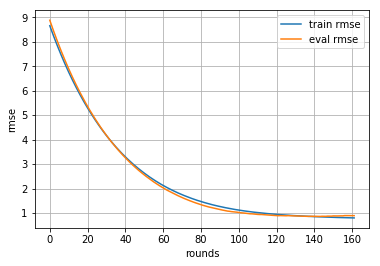

In [14]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

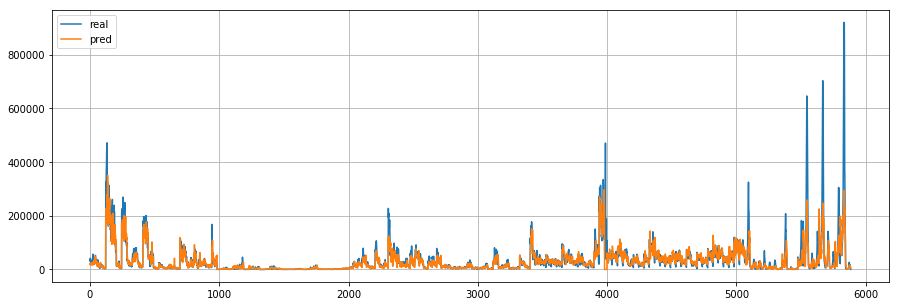

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

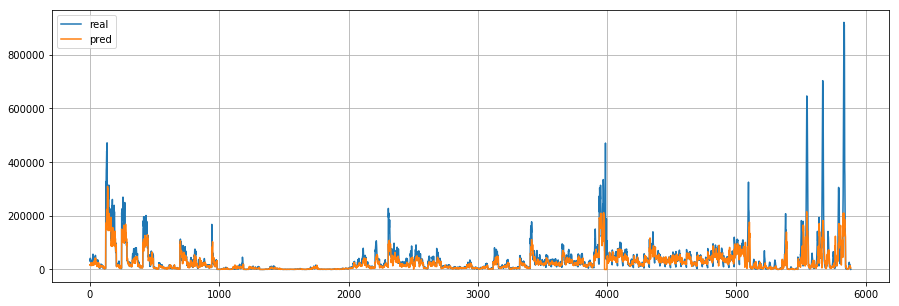

In [15]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

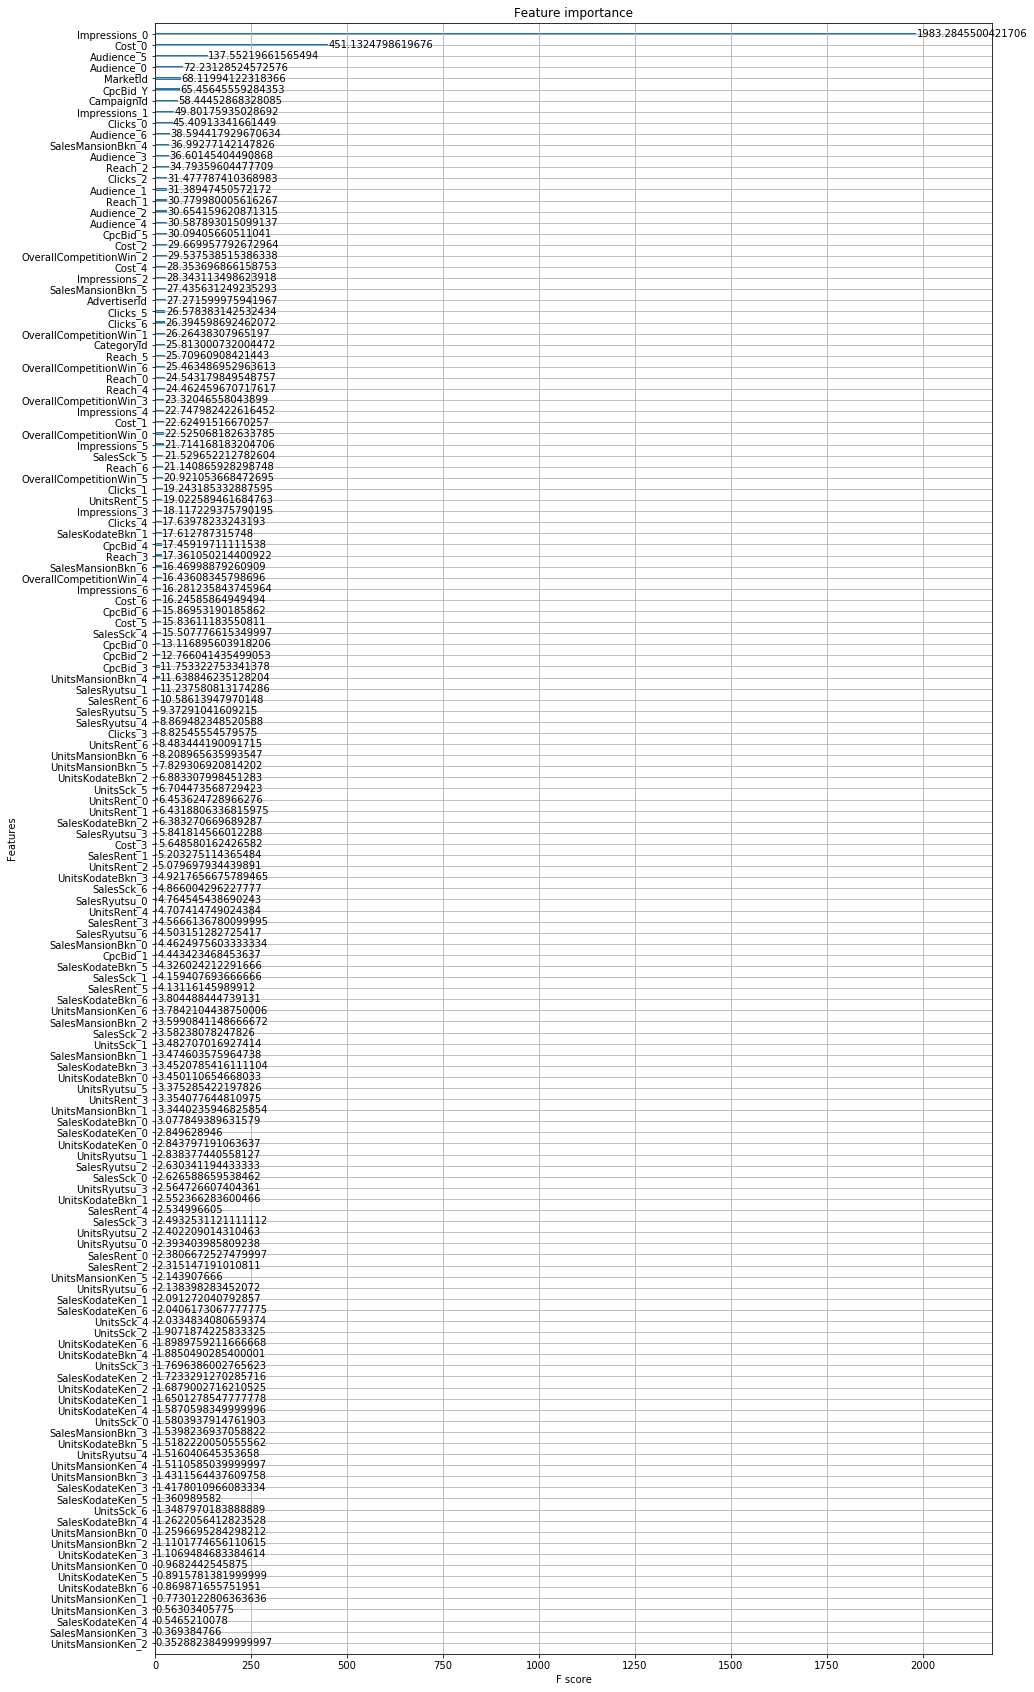

In [10]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Impressions_0',
 'Cost_0',
 'Audience_5',
 'Audience_0',
 'MarketId',
 'CpcBid_Y',
 'CampaignId',
 'Impressions_1',
 'Clicks_0',
 'Audience_6',
 'SalesMansionBkn_4',
 'Audience_3',
 'Reach_2',
 'Clicks_2',
 'Audience_1',
 'Reach_1',
 'Audience_2',
 'Audience_4',
 'CpcBid_5',
 'Cost_2',
 'OverallCompetitionWin_2',
 'Cost_4',
 'Impressions_2',
 'SalesMansionBkn_5',
 'AdvertiserId',
 'Clicks_5',
 'Clicks_6',
 'OverallCompetitionWin_1',
 'CategoryId',
 'Reach_5',
 'OverallCompetitionWin_6',
 'Reach_0',
 'Reach_4',
 'OverallCompetitionWin_3',
 'Impressions_4',
 'Cost_1',
 'OverallCompetitionWin_0',
 'Impressions_5',
 'SalesSck_5',
 'Reach_6',
 'OverallCompetitionWin_5',
 'Clicks_1',
 'UnitsRent_5',
 'Impressions_3',
 'Clicks_4',
 'SalesKodateBkn_1',
 'CpcBid_4',
 'Reach_3',
 'SalesMansionBkn_6',
 'OverallCompetitionWin_4',
 'Impressions_6',
 'Cost_6',
 'CpcBid_6',
 'Cost_5',
 'SalesSck_4',
 'CpcBid_0',
 'CpcBid_2',
 'CpcBid_3',
 'UnitsMansionBkn_4',
 'SalesRyutsu_1',
 'SalesRent_6',
 'Sal